# People Analytic - Data Hackathon 2021 Competition

## Import Package

In [1]:
# !pip install jcopml
# !pip install gdown

In [2]:
# !gdown https://drive.google.com/uc?id=1y3X2MfdCs_-cL-gD7BuKgCePn4K_JK4a

In [3]:
# !unzip /content/bri-data-hackathon-people-analytic.zip

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value, plot_classification_report, plot_confusion_matrix, plot_roc_curve
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease

# model arsitektur
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# fine-tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from jcopml.tuning import grid_search_params as gsp
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning import bayes_search_params as bsp
from sklearn.metrics import roc_auc_score

pd.options.display.max_columns=100

C:\Users\Ridho Alhafizhi\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


## Import Data

In [363]:
df = pd.read_csv("../data/bri-data-hackathon-people-analytic/train.csv")
df.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Best Performance,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,8.00,PG06,8.00,0.50,RM_type_A,Permanent,Female,1964,Y,3,1,2,level_4,2.32,1987,30.0,30,9,7,0,8,0,0,68.85,72.53,0.0,achiev_50%-100%,achiev_< 50%,reached
1,JG04,5.17,PG04,2.00,1.25,RM_type_A,Permanent,Male,1979,Y,3,2,1,level_4,3.25,2001,15.0,16,7,7,9,3,0,0,94.81,101.13,3.0,achiev_50%-100%,achiev_50%-100%,reached
2,JG04,1.83,PG03,1.83,1.50,RM_type_A,Permanent,Male,1980,Y,1,0,1,level_5,3.23,2007,15.0,15,9,9,0,6,0,0,72.82,71.30,0.0,achiev_100%-150%,achiev_< 50%,not_reached
3,JG04,7.92,PG04,4.00,0.17,RM_type_A,Permanent,Male,1984,Y,0,0,0,level_3,0.00,2006,8.0,8,5,5,0,3,0,0,86.89,90.09,2.0,achiev_50%-100%,achiev_50%-100%,not_reached
4,JG04,1.83,PG03,1.83,2.08,RM_type_A,Permanent,Male,1984,Y,1,0,1,NaN,NaN,NaN,7.0,7,4,6,11,2,1,1,95.17,100.72,2.0,achiev_< 50%,achiev_> 1.5,not_reached


## EDA (Eksploratory Data Analysis) and Feature Engineering

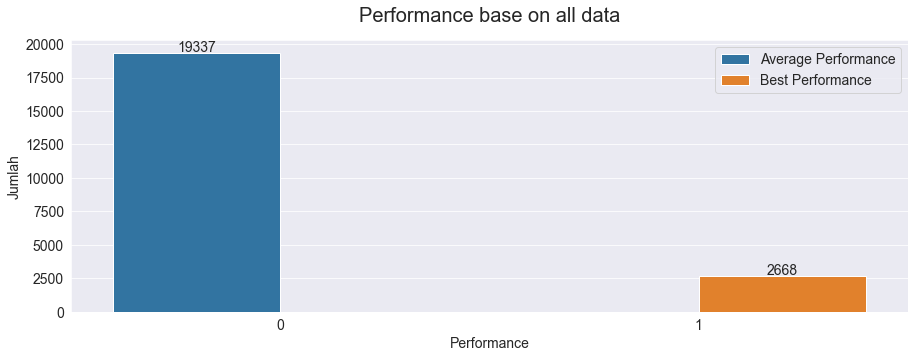

In [364]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 5))
plot = sns.countplot(data=df, x = 'Best Performance', hue =df['Best Performance'])
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points', fontsize=14)
    plt.title('Performance base on all data', fontsize=20, pad=18)
    plt.legend(['Average Performance', 'Best Performance'], fontsize=14)
    plt.xlabel('Performance', fontsize=14); plt.ylabel('Jumlah', fontsize=14);
    plt.yticks(fontsize=14);plt.xticks(fontsize=14)

### Cek Duplikasi

In [365]:
df.duplicated().sum()

111

In [366]:
df.drop_duplicates(inplace=True)

In [367]:
df.duplicated().sum()

0

### Ubah Value >> Duplikasi >> achievement_target_1_2_3

In [368]:
#Merubah Value achievement_target_1
df = df.copy()
df['achievement_target_1'] = df['achievement_target_1'].apply({"achiev_50%-100%":"Pencapaian 50%-100%",
                                                                       "achiev_100%-150%":"Pencapaian 100%-150%",
                                                                       "achiev_< 50%":"Pencapaian < 50%",
                                                                       "achiev_> 1.5":"Pencapaian > 1.5",
                                                                       "Tidak diberikan target":"Tidak diberikan target",
                                                                       "Pencapaian 50%-100%":"Pencapaian 50%-100%",
                                                                       "Pencapaian < 50%":"Pencapaian < 50%",
                                                                       "Pencapaian 100%-150%":"Pencapaian 100%-150%",
                                                                       "Pencapaian > 1.5":"Pencapaian > 1.5"}.get)
df.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Best Performance,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,8.00,PG06,8.00,0.50,RM_type_A,Permanent,Female,1964,Y,3,1,2,level_4,2.32,1987,30.0,30,9,7,0,8,0,0,68.85,72.53,0.0,Pencapaian 50%-100%,achiev_< 50%,reached
1,JG04,5.17,PG04,2.00,1.25,RM_type_A,Permanent,Male,1979,Y,3,2,1,level_4,3.25,2001,15.0,16,7,7,9,3,0,0,94.81,101.13,3.0,Pencapaian 50%-100%,achiev_50%-100%,reached
2,JG04,1.83,PG03,1.83,1.50,RM_type_A,Permanent,Male,1980,Y,1,0,1,level_5,3.23,2007,15.0,15,9,9,0,6,0,0,72.82,71.30,0.0,Pencapaian 100%-150%,achiev_< 50%,not_reached
3,JG04,7.92,PG04,4.00,0.17,RM_type_A,Permanent,Male,1984,Y,0,0,0,level_3,0.00,2006,8.0,8,5,5,0,3,0,0,86.89,90.09,2.0,Pencapaian 50%-100%,achiev_50%-100%,not_reached
4,JG04,1.83,PG03,1.83,2.08,RM_type_A,Permanent,Male,1984,Y,1,0,1,NaN,NaN,NaN,7.0,7,4,6,11,2,1,1,95.17,100.72,2.0,Pencapaian < 50%,achiev_> 1.5,not_reached


In [369]:
#Merubah Value achievement_target_2
df = df.copy()
df['achievement_target_2'] = df['achievement_target_2'].apply({"achiev_50%-100%":"Pencapaian 50%-100%",
                                                                       "achiev_100%-150%":"Pencapaian 100%-150%",
                                                                       "achiev_< 50%":"Pencapaian < 50%",
                                                                       "achiev_> 1.5":"Pencapaian > 1.5",
                                                                       "Tidak diberikan target":"Tidak diberikan target",
                                                                       "Pencapaian 50%-100%":"Pencapaian 50%-100%",
                                                                       "Pencapaian < 50%":"Pencapaian < 50%",
                                                                       "Pencapaian 100%-150%":"Pencapaian 100%-150%",
                                                                       "Pencapaian > 1.5":"Pencapaian > 1.5"}.get)
df.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Best Performance,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,8.00,PG06,8.00,0.50,RM_type_A,Permanent,Female,1964,Y,3,1,2,level_4,2.32,1987,30.0,30,9,7,0,8,0,0,68.85,72.53,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
1,JG04,5.17,PG04,2.00,1.25,RM_type_A,Permanent,Male,1979,Y,3,2,1,level_4,3.25,2001,15.0,16,7,7,9,3,0,0,94.81,101.13,3.0,Pencapaian 50%-100%,Pencapaian 50%-100%,reached
2,JG04,1.83,PG03,1.83,1.50,RM_type_A,Permanent,Male,1980,Y,1,0,1,level_5,3.23,2007,15.0,15,9,9,0,6,0,0,72.82,71.30,0.0,Pencapaian 100%-150%,Pencapaian < 50%,not_reached
3,JG04,7.92,PG04,4.00,0.17,RM_type_A,Permanent,Male,1984,Y,0,0,0,level_3,0.00,2006,8.0,8,5,5,0,3,0,0,86.89,90.09,2.0,Pencapaian 50%-100%,Pencapaian 50%-100%,not_reached
4,JG04,1.83,PG03,1.83,2.08,RM_type_A,Permanent,Male,1984,Y,1,0,1,NaN,NaN,NaN,7.0,7,4,6,11,2,1,1,95.17,100.72,2.0,Pencapaian < 50%,Pencapaian > 1.5,not_reached


In [370]:
#Merubah Value achievement_target_3
df = df.copy()
df['achievement_target_3'] = df['achievement_target_3'].apply({"not_reached":"not reached","reached":"reached","not reached":"not reached"}.get)
df.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Best Performance,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,8.00,PG06,8.00,0.50,RM_type_A,Permanent,Female,1964,Y,3,1,2,level_4,2.32,1987,30.0,30,9,7,0,8,0,0,68.85,72.53,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
1,JG04,5.17,PG04,2.00,1.25,RM_type_A,Permanent,Male,1979,Y,3,2,1,level_4,3.25,2001,15.0,16,7,7,9,3,0,0,94.81,101.13,3.0,Pencapaian 50%-100%,Pencapaian 50%-100%,reached
2,JG04,1.83,PG03,1.83,1.50,RM_type_A,Permanent,Male,1980,Y,1,0,1,level_5,3.23,2007,15.0,15,9,9,0,6,0,0,72.82,71.30,0.0,Pencapaian 100%-150%,Pencapaian < 50%,not reached
3,JG04,7.92,PG04,4.00,0.17,RM_type_A,Permanent,Male,1984,Y,0,0,0,level_3,0.00,2006,8.0,8,5,5,0,3,0,0,86.89,90.09,2.0,Pencapaian 50%-100%,Pencapaian 50%-100%,not reached
4,JG04,1.83,PG03,1.83,2.08,RM_type_A,Permanent,Male,1984,Y,1,0,1,NaN,NaN,NaN,7.0,7,4,6,11,2,1,1,95.17,100.72,2.0,Pencapaian < 50%,Pencapaian > 1.5,not reached


### Cek balance?

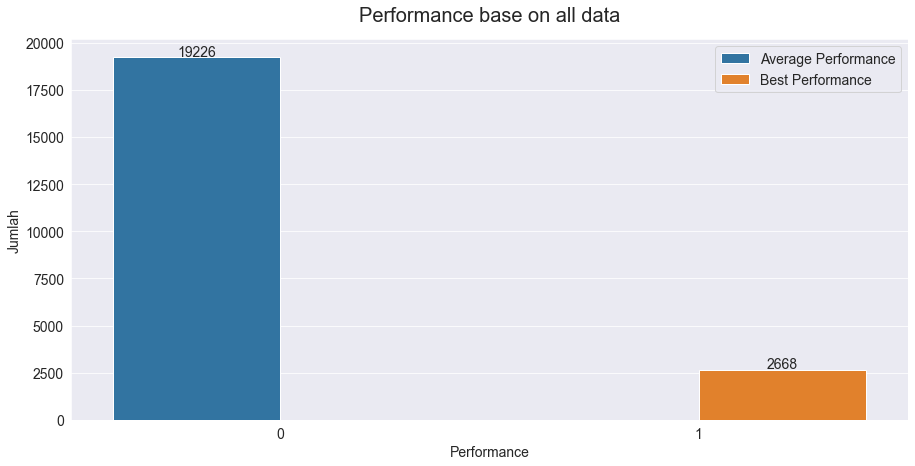

In [371]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 7))
plot = sns.countplot(data=df, x = 'Best Performance', hue =df['Best Performance'])
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points', fontsize=14)
    plt.title('Performance base on all data', fontsize=20, pad=18)
    plt.legend(['Average Performance', 'Best Performance'], fontsize=14)
    plt.xlabel('Performance', fontsize=14); plt.ylabel('Jumlah', fontsize=14);
    plt.yticks(fontsize=14);plt.xticks(fontsize=14)

<ul>
    <li>Dataset tersebut imbalance</li>
        </ul>

### Data Kategori

#### Gender

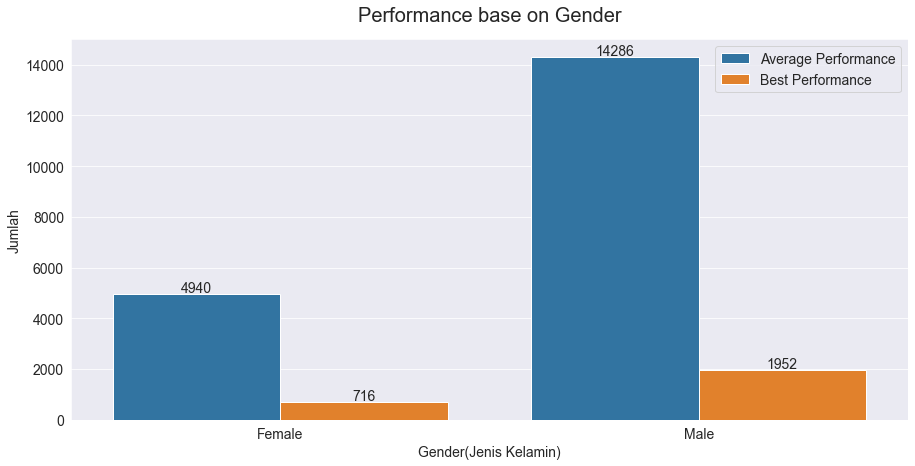

In [372]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 7))

plot = sns.countplot(data=df, x = 'gender', hue ='Best Performance')
for p in plot.patches:
    
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 6), textcoords = 'offset points', fontsize=14)
    plt.title('Performance base on Gender', fontsize=20, pad=18)
    plt.legend(['Average Performance', 'Best Performance'], fontsize=14)
    plt.xlabel('Gender(Jenis Kelamin)', fontsize=14); plt.ylabel('Jumlah', fontsize=14);
    plt.yticks(fontsize=14);plt.xticks(fontsize=14)

<ul>Berdasarkan plot pada <b>performance based on gender</b> tersebut, maka dapat disimpulkan bahwa:
    <li>Pada jenis kelamin pria (male) menunjukkan pria lebih produktif dibandingkan dengan wanita, karena jumlah pekerja pria lebih banyak dibandingkan dgn wanita (apabila jika dilihat pada jumlah orang dengan predikat `Best Performance`)</li>
    </ul>

#### Employee Type

In [373]:
#Merubah Value Employee Type
df = df.copy()
df['Employee_type'] = df['Employee_type'].apply({
                       'RM_type_A': 'Mantri Kupedes',
                       'RM_type_B': 'Mantri KUR',
                       'RM_type_C': 'Mantri Briguna'}.get)
df.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Best Performance,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,8.00,PG06,8.00,0.50,Mantri Kupedes,Permanent,Female,1964,Y,3,1,2,level_4,2.32,1987,30.0,30,9,7,0,8,0,0,68.85,72.53,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
1,JG04,5.17,PG04,2.00,1.25,Mantri Kupedes,Permanent,Male,1979,Y,3,2,1,level_4,3.25,2001,15.0,16,7,7,9,3,0,0,94.81,101.13,3.0,Pencapaian 50%-100%,Pencapaian 50%-100%,reached
2,JG04,1.83,PG03,1.83,1.50,Mantri Kupedes,Permanent,Male,1980,Y,1,0,1,level_5,3.23,2007,15.0,15,9,9,0,6,0,0,72.82,71.30,0.0,Pencapaian 100%-150%,Pencapaian < 50%,not reached
3,JG04,7.92,PG04,4.00,0.17,Mantri Kupedes,Permanent,Male,1984,Y,0,0,0,level_3,0.00,2006,8.0,8,5,5,0,3,0,0,86.89,90.09,2.0,Pencapaian 50%-100%,Pencapaian 50%-100%,not reached
4,JG04,1.83,PG03,1.83,2.08,Mantri Kupedes,Permanent,Male,1984,Y,1,0,1,NaN,NaN,NaN,7.0,7,4,6,11,2,1,1,95.17,100.72,2.0,Pencapaian < 50%,Pencapaian > 1.5,not reached


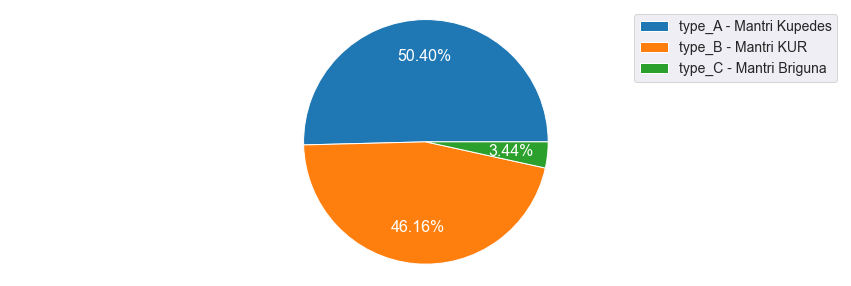

In [374]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 5))

plot = plt.pie(x=df.Employee_type.value_counts(),autopct='%1.2f%%',pctdistance=0.7,
               textprops={'color': 'white', 'fontsize': 16})
plt.legend(['type_A - Mantri Kupedes', 'type_B - Mantri KUR', 'type_C - Mantri Briguna'], fontsize=14)
plt.axis('equal');plt.show();


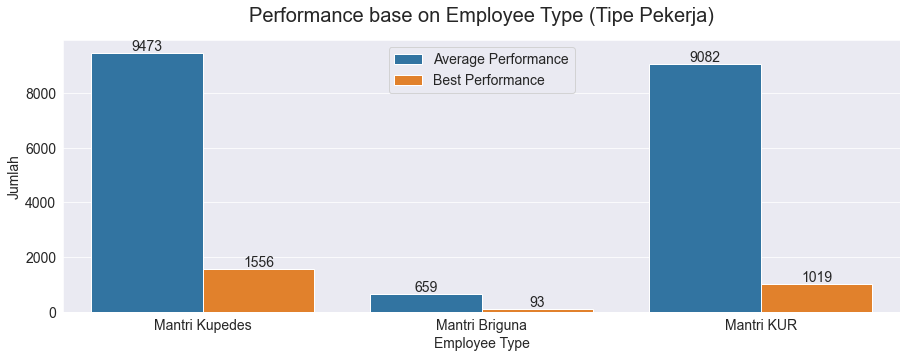

In [375]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 5))

plot = sns.countplot(data=df, x = 'Employee_type', hue ='Best Performance')
for p in plot.patches:
    
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 6), textcoords = 'offset points', fontsize=14)
    plt.title('Performance base on Employee Type (Tipe Pekerja)', fontsize=20, pad=18)
    plt.legend(['Average Performance', 'Best Performance'], fontsize=14)
    plt.xlabel('Employee Type', fontsize=14); plt.ylabel('Jumlah', fontsize=14);
    plt.yticks(fontsize=14);plt.xticks(fontsize=14)

<ul>Berdasarkan plot pada <b>performance based on Employee Type</b> tersebut, maka dapat disimpulkan bahwa:
    <li>tipe A, yaitu mantri kupedes memiliki jumlah pekerja yang paling banyak (dominan) sekitar 50.4%, diposisi ke-2 dan ke-3 yaitu tipe B dan C</li>
    <li>Berdasarkan data tersebut, pekerja dengan tipe A memiliki kinerja terbaik jika dibandingkan dgn 2 tipe pekerja lainnya</li>
    </ul>

#### Employee Status

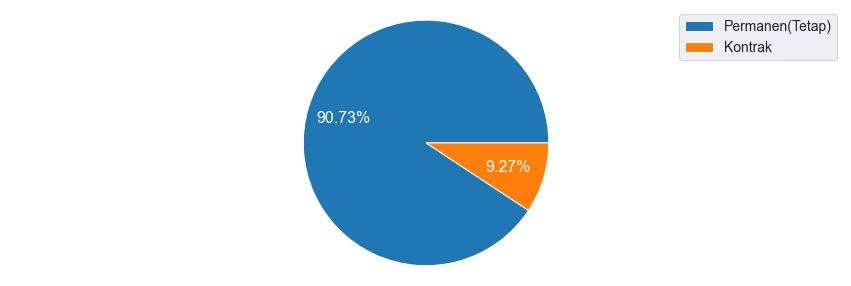

In [376]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 5))

plot = plt.pie(x=df.Employee_status.value_counts(),autopct='%1.2f%%',pctdistance=0.7,
               textprops={'color': 'white', 'fontsize': 16})
plt.legend(['Permanen(Tetap)', 'Kontrak'], fontsize=14)
plt.axis('equal');plt.show();

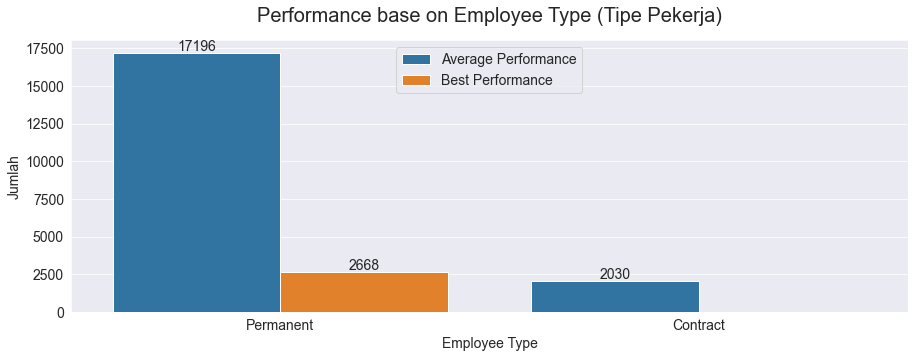

In [377]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 5))

plot = sns.countplot(data=df, x = 'Employee_status', hue ='Best Performance')
for p in plot.patches:
    
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 6), textcoords = 'offset points', fontsize=14)
    plt.title('Performance base on Employee Type (Tipe Pekerja)', fontsize=20, pad=18)
    plt.legend(['Average Performance', 'Best Performance'], fontsize=14)
    plt.xlabel('Employee Type', fontsize=14); plt.ylabel('Jumlah', fontsize=14);
    plt.yticks(fontsize=14);plt.xticks(fontsize=14)

<ul>Berdasarkan plot pada <b>performance based on Employee Status</b> tersebut, maka dapat disimpulkan bahwa:
    <li>status pekerja tetap akan mempengaruhi terhadap kinerja karyawan </li>
</ul>

#### marital_status_maried(Y/N)

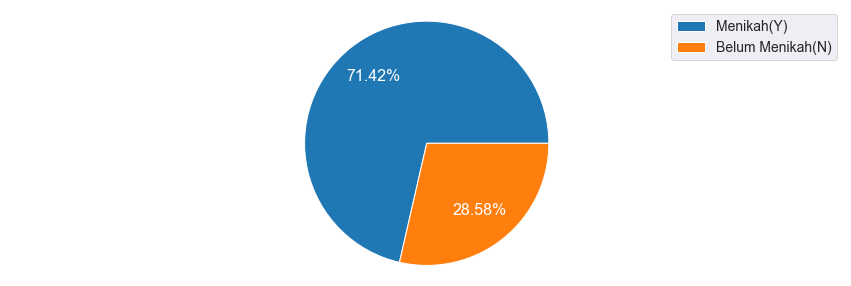

In [378]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 5))

plot = plt.pie(x=df['marital_status_maried(Y/N)'].value_counts(),autopct='%1.2f%%',pctdistance=0.7,
               textprops={'color': 'white', 'fontsize': 16})
plt.legend(['Menikah(Y)', 'Belum Menikah(N)'], fontsize=14)
plt.axis('equal');plt.show();

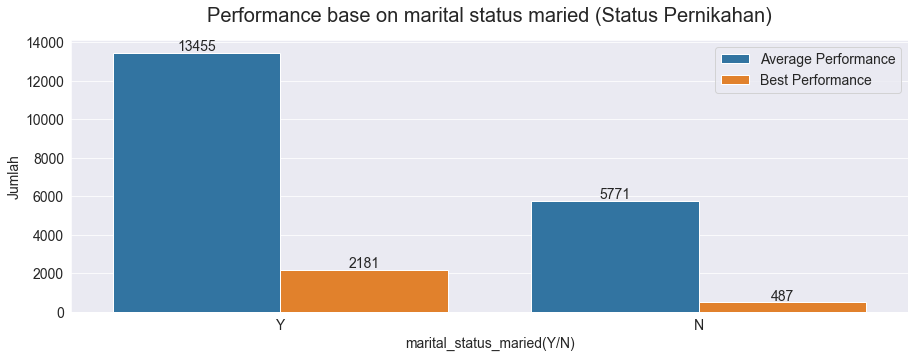

In [379]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 5))

plot = sns.countplot(data=df, x = 'marital_status_maried(Y/N)', hue ='Best Performance')
for p in plot.patches:
    
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 6), textcoords = 'offset points', fontsize=14)
    plt.title('Performance base on marital status maried (Status Pernikahan)', fontsize=20, pad=18)
    plt.legend(['Average Performance', 'Best Performance'], fontsize=14)
    plt.xlabel('marital_status_maried(Y/N)', fontsize=14); plt.ylabel('Jumlah', fontsize=14);
    plt.yticks(fontsize=14);plt.xticks(fontsize=14)

<ul>Berdasarkan plot pada <b>performance based on Marital Status Maried</b> tersebut, maka dapat disimpulkan bahwa:
    <li>pekerja yang sudah menikah cenderung lebih produktif jika dibandingkan dengan pekerja yg belum menikah dgn tingkat perbandingan yang cukup signifikan </li>
</ul>

#### achievement_target_1

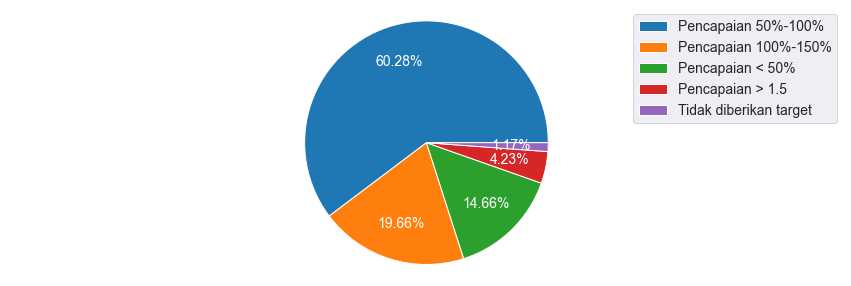

In [380]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 5))

plot = plt.pie(x=df['achievement_target_1'].value_counts(),autopct='%1.2f%%',pctdistance=0.7,
               textprops={'color': 'white', 'fontsize': 14})
plt.legend(["Pencapaian 50%-100%","Pencapaian 100%-150%",
            "Pencapaian < 50%","Pencapaian > 1.5","Tidak diberikan target"], fontsize=14)
plt.axis('equal');plt.show();

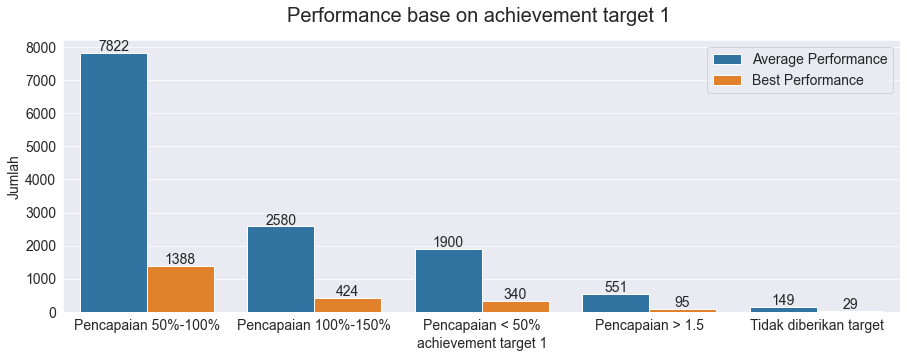

In [381]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 5))

plot = sns.countplot(data=df, x = 'achievement_target_1', hue ='Best Performance')
for p in plot.patches:
    
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 6), textcoords = 'offset points', fontsize=14)
    plt.title('Performance base on achievement target 1 ', fontsize=20, pad=18)
    plt.legend(['Average Performance', 'Best Performance'], fontsize=14)
    plt.xlabel('achievement target 1', fontsize=14); plt.ylabel('Jumlah', fontsize=14);
    plt.yticks(fontsize=14);plt.xticks(fontsize=14)

#### achievement_target_2

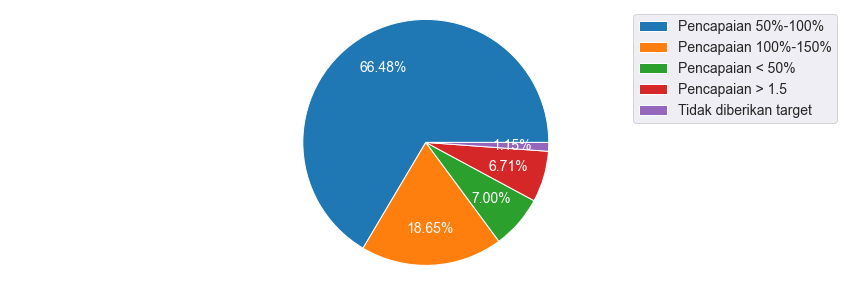

In [382]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 5))

plot = plt.pie(x=df['achievement_target_2'].value_counts(),autopct='%1.2f%%',pctdistance=0.7,
               textprops={'color': 'white', 'fontsize': 14})
plt.legend(["Pencapaian 50%-100%","Pencapaian 100%-150%","Pencapaian < 50%",
            "Pencapaian > 1.5","Tidak diberikan target"], fontsize=14)
plt.axis('equal');plt.show();

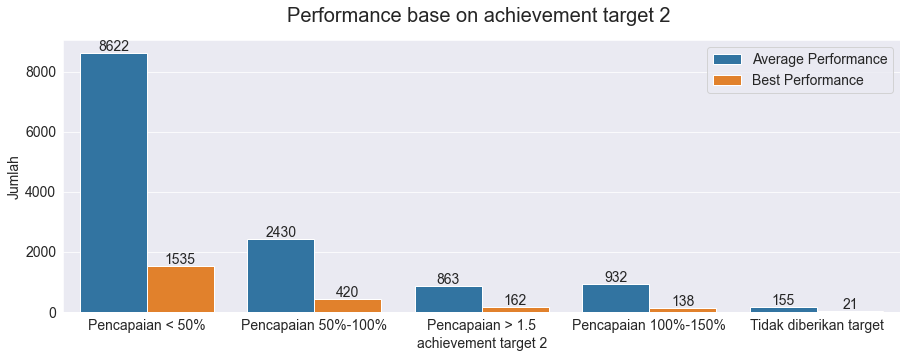

In [383]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 5))

plot = sns.countplot(data=df, x = 'achievement_target_2', hue ='Best Performance')
for p in plot.patches:
    
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 6), textcoords = 'offset points', fontsize=14)
    plt.title('Performance base on achievement target 2 ', fontsize=20, pad=18)
    plt.legend(['Average Performance', 'Best Performance'], fontsize=14)
    plt.xlabel('achievement target 2', fontsize=14); plt.ylabel('Jumlah', fontsize=14);
    plt.yticks(fontsize=14);plt.xticks(fontsize=14)

#### achievement_target_3

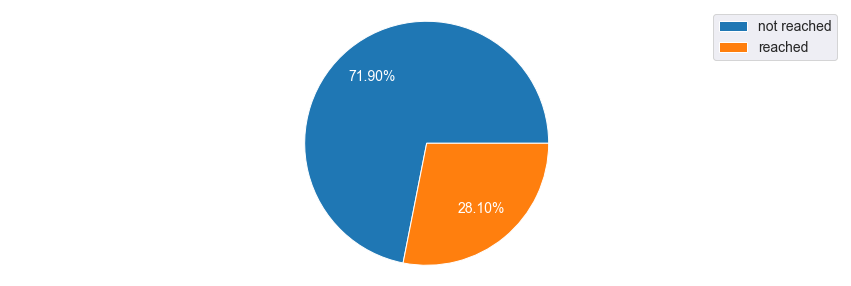

In [384]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 5))

plot = plt.pie(x=df['achievement_target_3'].value_counts(),autopct='%1.2f%%',pctdistance=0.7,
               textprops={'color': 'white', 'fontsize': 14})
plt.legend(["not reached","reached"], fontsize=14)
plt.axis('equal');plt.show();

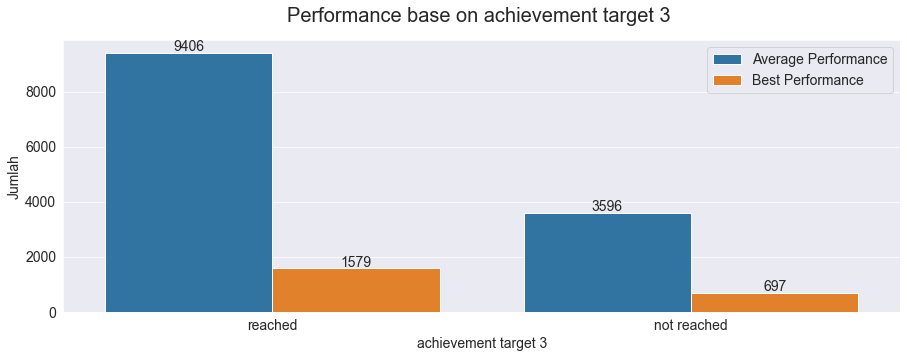

In [385]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 5))

plot = sns.countplot(data=df, x = 'achievement_target_3', hue ='Best Performance')
for p in plot.patches:
    
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 6), textcoords = 'offset points', fontsize=14)
    plt.title('Performance base on achievement target 3 ', fontsize=20, pad=18)
    plt.legend(['Average Performance', 'Best Performance'], fontsize=14)
    plt.xlabel('achievement target 3', fontsize=14); plt.ylabel('Jumlah', fontsize=14);
    plt.yticks(fontsize=14);plt.xticks(fontsize=14)

#### Person Level

In [386]:
df['person_level'].unique()

array(['PG06', 'PG04', 'PG03', 'PG05', 'PG01', 'PG02', 'PG07', 'PG08'],
      dtype=object)

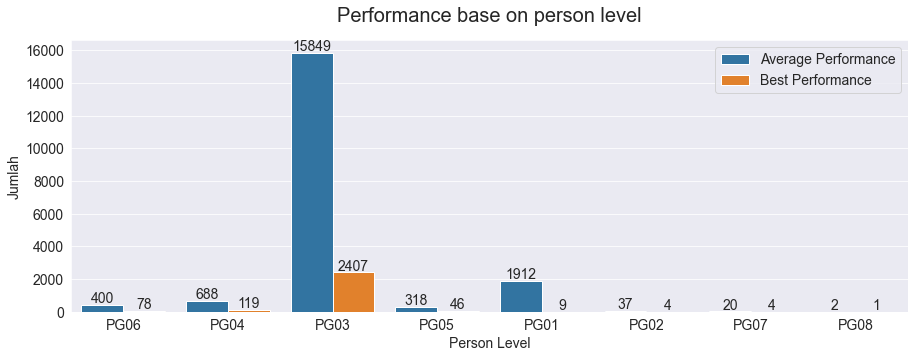

In [387]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 5))

plot = sns.countplot(data=df, x = 'person_level', hue ='Best Performance')
for p in plot.patches:
    
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 6), textcoords = 'offset points', fontsize=14)
    plt.title('Performance base on person level', fontsize=20, pad=18)
    plt.legend(['Average Performance', 'Best Performance'], fontsize=14)
    plt.xlabel('Person Level', fontsize=14); plt.ylabel('Jumlah', fontsize=14);
    plt.yticks(fontsize=14);plt.xticks(fontsize=14)

<ul>Berdasarkan plot pada <b>performance based on person level</b> tersebut, maka dapat disimpulkan bahwa:
    <li>Performance terbaik terdapat pada level (PG03), dan pada level 3 mempunyai banyak pekerja </li>
    </ul>

#### Job Level

In [388]:
df['job_level'].unique()

array(['JG05', 'JG04', 'JG03', 'JG06'], dtype=object)

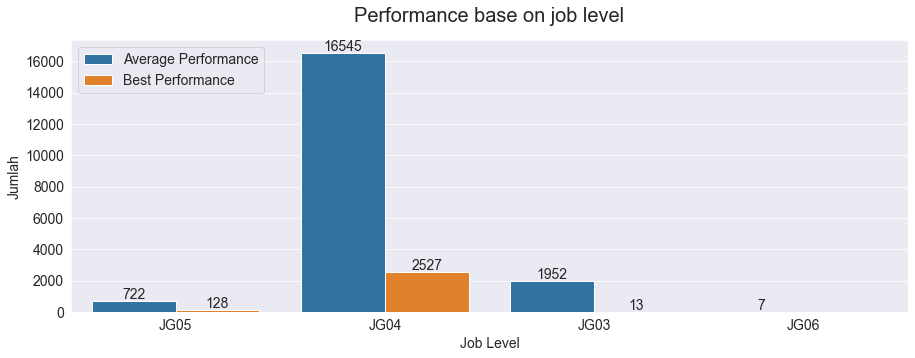

In [389]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 5))

plot = sns.countplot(data=df, x = 'job_level', hue ='Best Performance')
for p in plot.patches:
    
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 6), textcoords = 'offset points', fontsize=14)
    plt.title('Performance base on job level', fontsize=20, pad=18)
    plt.legend(['Average Performance', 'Best Performance'], fontsize=14)
    plt.xlabel('Job Level', fontsize=14); plt.ylabel('Jumlah', fontsize=14);
    plt.yticks(fontsize=14);plt.xticks(fontsize=14)

<ul>Berdasarkan plot pada <b>performance based on job level</b> tersebut, maka dapat disimpulkan bahwa:
    <li>Performance terbaik terdapat pada level 2 (JG04), dan pada level 2 mempunyai banyak pekerja </li>
    </ul>

#### Educational Level

In [390]:
#Merubah Value Employee Type
df = df.copy()
df['Education_level'] = df['Education_level'].apply({
                       'level_0': 'Internal course',
                       'level_1': 'SLTA',
                       'level_2': 'D1',
                       'level_3': 'D3/D4',
                       'level_4': 'S1',
                       'level_5': 'S2'}.get)
df.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Best Performance,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,8.00,PG06,8.00,0.50,Mantri Kupedes,Permanent,Female,1964,Y,3,1,2,S1,2.32,1987,30.0,30,9,7,0,8,0,0,68.85,72.53,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
1,JG04,5.17,PG04,2.00,1.25,Mantri Kupedes,Permanent,Male,1979,Y,3,2,1,S1,3.25,2001,15.0,16,7,7,9,3,0,0,94.81,101.13,3.0,Pencapaian 50%-100%,Pencapaian 50%-100%,reached
2,JG04,1.83,PG03,1.83,1.50,Mantri Kupedes,Permanent,Male,1980,Y,1,0,1,S2,3.23,2007,15.0,15,9,9,0,6,0,0,72.82,71.30,0.0,Pencapaian 100%-150%,Pencapaian < 50%,not reached
3,JG04,7.92,PG04,4.00,0.17,Mantri Kupedes,Permanent,Male,1984,Y,0,0,0,D3/D4,0.00,2006,8.0,8,5,5,0,3,0,0,86.89,90.09,2.0,Pencapaian 50%-100%,Pencapaian 50%-100%,not reached
4,JG04,1.83,PG03,1.83,2.08,Mantri Kupedes,Permanent,Male,1984,Y,1,0,1,None,NaN,NaN,7.0,7,4,6,11,2,1,1,95.17,100.72,2.0,Pencapaian < 50%,Pencapaian > 1.5,not reached


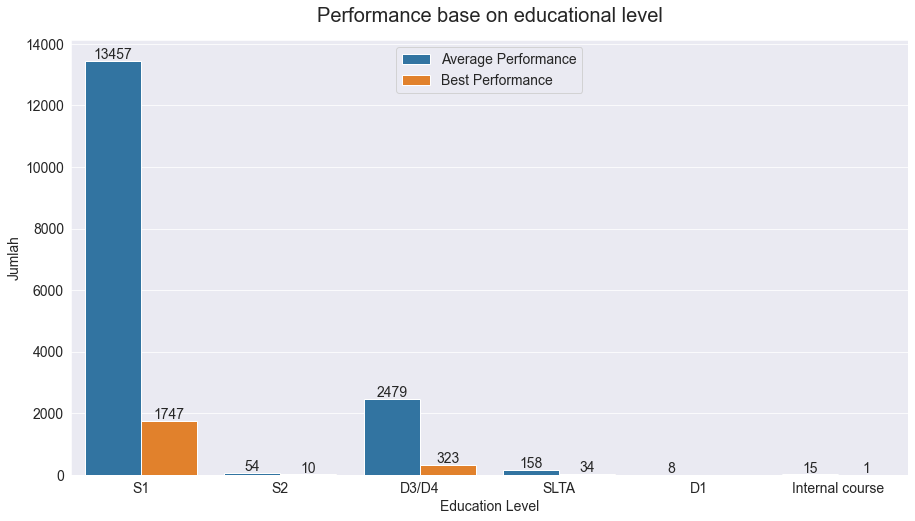

In [391]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 8))

plot = sns.countplot(data=df, x = 'Education_level', hue ='Best Performance')
for p in plot.patches:
    
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 6), textcoords = 'offset points', fontsize=14)
    plt.title('Performance base on educational level', fontsize=20, pad=18)
    plt.legend(['Average Performance', 'Best Performance'], fontsize=14)
    plt.xlabel('Education Level', fontsize=14); plt.ylabel('Jumlah', fontsize=14);
    plt.yticks(fontsize=14);plt.xticks(fontsize=14)

<ul>Berdasarkan plot pada <b>performance based on education level</b> tersebut, maka dapat disimpulkan bahwa:
    <li>Performnace terbaik terdapat pada lulusan S1 dan pekerja tersebut, didominasi oleh lulusan S1</li>
    </ul>

### Data Numerik

#### Age

In [392]:
#Merubah tahun lahir menjadi usia
df = df.copy()
df['age'] = 2020 - df['age']
df.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Best Performance,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,8.00,PG06,8.00,0.50,Mantri Kupedes,Permanent,Female,56,Y,3,1,2,S1,2.32,1987,30.0,30,9,7,0,8,0,0,68.85,72.53,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
1,JG04,5.17,PG04,2.00,1.25,Mantri Kupedes,Permanent,Male,41,Y,3,2,1,S1,3.25,2001,15.0,16,7,7,9,3,0,0,94.81,101.13,3.0,Pencapaian 50%-100%,Pencapaian 50%-100%,reached
2,JG04,1.83,PG03,1.83,1.50,Mantri Kupedes,Permanent,Male,40,Y,1,0,1,S2,3.23,2007,15.0,15,9,9,0,6,0,0,72.82,71.30,0.0,Pencapaian 100%-150%,Pencapaian < 50%,not reached
3,JG04,7.92,PG04,4.00,0.17,Mantri Kupedes,Permanent,Male,36,Y,0,0,0,D3/D4,0.00,2006,8.0,8,5,5,0,3,0,0,86.89,90.09,2.0,Pencapaian 50%-100%,Pencapaian 50%-100%,not reached
4,JG04,1.83,PG03,1.83,2.08,Mantri Kupedes,Permanent,Male,36,Y,1,0,1,None,NaN,NaN,7.0,7,4,6,11,2,1,1,95.17,100.72,2.0,Pencapaian < 50%,Pencapaian > 1.5,not reached


##### Cek Outlier?

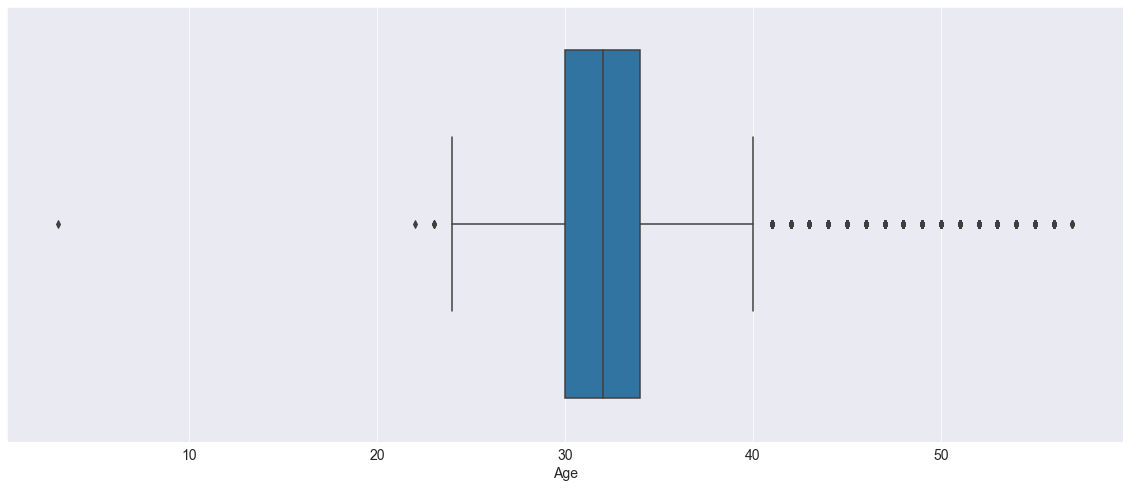

In [393]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x=df["age"])

plt.xlabel('Age', fontsize=14);
plt.yticks(fontsize=14);plt.xticks(fontsize=14);

<ul>Berdasarkan boxplot pada <b>kolom age</b> tersebut, maka dapat disimpulkan bahwa:
    <li>Terdapat pencilan (outlier), yaitu nilai = 3</li>
    </ul>

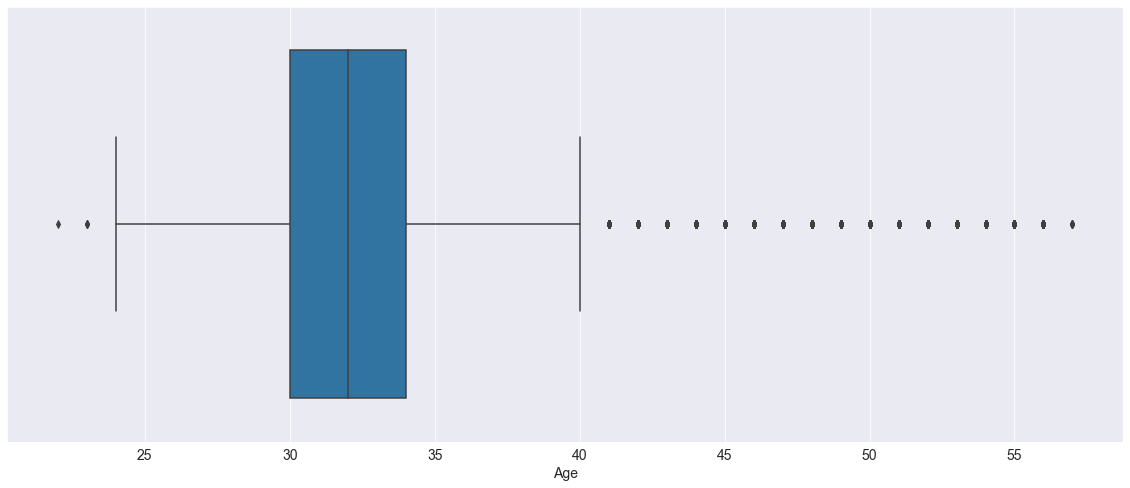

In [394]:
df.drop(df[df.age == 3].index, inplace=True) #hapus outlier (age)

#setelah oulier dihapus
sns.set_style(style="darkgrid")
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x=df["age"])

plt.xlabel('Age', fontsize=14);
plt.yticks(fontsize=14);plt.xticks(fontsize=14);

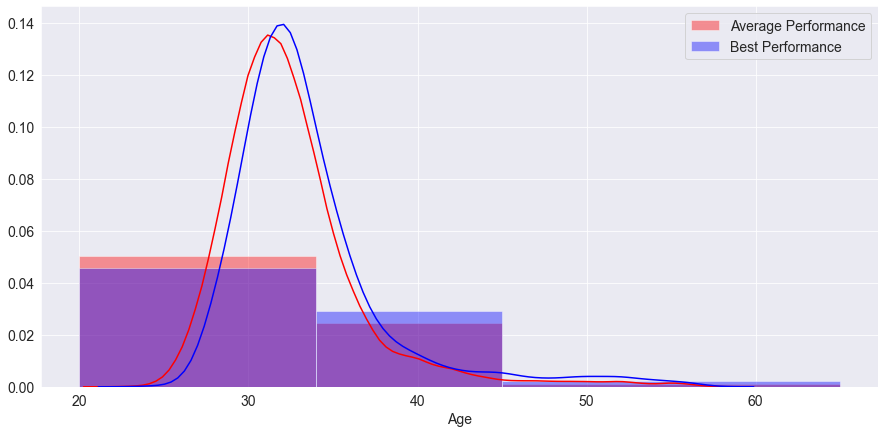

In [395]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 7))
sns.distplot(df.age[df['Best Performance'] == 0], bins=[20, 34, 45, 65], color="r", label="Average Performance")
sns.distplot(df.age[df['Best Performance'] == 1], bins=[20, 34, 45, 65], color="b", label="Best Performance")
plt.legend(['Average Performance', 'Best Performance'], fontsize=14)
plt.xlabel('Age', fontsize=14);
plt.yticks(fontsize=14);plt.xticks(fontsize=14);

<ul>Berdasarkan histogram pada <b>kolom age</b> tersebut, maka dapat disimpulkan bahwa:
    <li>usia 20-30 tahun memiliki kinerja yang cukup baik</li>
    <li>usia 30-40 tahun merupakan usia yang produktif (memiliki kinerja terbaik)</li>
    <li>usia >40 tahun memiliki kinerja yg kurang produktif</li>
    </ul>

#### Year Graduate

In [396]:
df['year_graduated'].unique()

array(['1987', '2001', '2007', '2006', nan, '2008', '2011', '2010',
       '2013', '2014', '\\N', '1996', '2009', '2005', '2012', '1989',
       '1992', '0', '2000', '1994', '1997', '1993', '1995', '2004',
       '2015', '1986', '1999', '2003', '2016', '2044', '2018', '1991',
       '2002', '2017', '2201', '1998', '1990', '9999', '1984', '2020',
       '1988', '1983', '1985', '201', '2019', '2031', '____', '3016', '-',
       '2200', '102', '2999', '9464'], dtype=object)

In [397]:
df.drop((df[df.year_graduated == '\\N'].index) | (df[df.year_graduated == '0'].index)|
        (df[df.year_graduated == '2044'].index) | (df[df.year_graduated == '2201'].index | 
        (df[df.year_graduated == '9999'].index) | (df[df.year_graduated == '201'].index) | 
        (df[df.year_graduated == '2031'].index) |  (df[df.year_graduated == '____'].index) | 
        (df[df.year_graduated == '2200'].index) | (df[df.year_graduated == '3016'].index) | 
        (df[df.year_graduated == '102'].index) |  (df[df.year_graduated == '2999'].index) | 
        (df[df.year_graduated == '9464'].index) | (df[df.year_graduated == '_'].index) | 
        (df[df.year_graduated == '-'].index)), inplace=True)

In [398]:
#convert string to numerik
df=df.copy()
df['year_graduated'] = pd.to_numeric(df['year_graduated'])
df.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Best Performance,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,8.00,PG06,8.00,0.50,Mantri Kupedes,Permanent,Female,56,Y,3,1,2,S1,2.32,1987.0,30.0,30,9,7,0,8,0,0,68.85,72.53,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
1,JG04,5.17,PG04,2.00,1.25,Mantri Kupedes,Permanent,Male,41,Y,3,2,1,S1,3.25,2001.0,15.0,16,7,7,9,3,0,0,94.81,101.13,3.0,Pencapaian 50%-100%,Pencapaian 50%-100%,reached
2,JG04,1.83,PG03,1.83,1.50,Mantri Kupedes,Permanent,Male,40,Y,1,0,1,S2,3.23,2007.0,15.0,15,9,9,0,6,0,0,72.82,71.30,0.0,Pencapaian 100%-150%,Pencapaian < 50%,not reached
3,JG04,7.92,PG04,4.00,0.17,Mantri Kupedes,Permanent,Male,36,Y,0,0,0,D3/D4,0.00,2006.0,8.0,8,5,5,0,3,0,0,86.89,90.09,2.0,Pencapaian 50%-100%,Pencapaian 50%-100%,not reached
4,JG04,1.83,PG03,1.83,2.08,Mantri Kupedes,Permanent,Male,36,Y,1,0,1,None,NaN,NaN,7.0,7,4,6,11,2,1,1,95.17,100.72,2.0,Pencapaian < 50%,Pencapaian > 1.5,not reached


In [399]:
#Merubah year_graduated menjadi jumlah waktu sudah lulus
df = df.copy()
df['year_graduated'] = 2020 - df['year_graduated']
df.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Best Performance,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,8.00,PG06,8.00,0.50,Mantri Kupedes,Permanent,Female,56,Y,3,1,2,S1,2.32,33.0,30.0,30,9,7,0,8,0,0,68.85,72.53,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
1,JG04,5.17,PG04,2.00,1.25,Mantri Kupedes,Permanent,Male,41,Y,3,2,1,S1,3.25,19.0,15.0,16,7,7,9,3,0,0,94.81,101.13,3.0,Pencapaian 50%-100%,Pencapaian 50%-100%,reached
2,JG04,1.83,PG03,1.83,1.50,Mantri Kupedes,Permanent,Male,40,Y,1,0,1,S2,3.23,13.0,15.0,15,9,9,0,6,0,0,72.82,71.30,0.0,Pencapaian 100%-150%,Pencapaian < 50%,not reached
3,JG04,7.92,PG04,4.00,0.17,Mantri Kupedes,Permanent,Male,36,Y,0,0,0,D3/D4,0.00,14.0,8.0,8,5,5,0,3,0,0,86.89,90.09,2.0,Pencapaian 50%-100%,Pencapaian 50%-100%,not reached
4,JG04,1.83,PG03,1.83,2.08,Mantri Kupedes,Permanent,Male,36,Y,1,0,1,None,NaN,NaN,7.0,7,4,6,11,2,1,1,95.17,100.72,2.0,Pencapaian < 50%,Pencapaian > 1.5,not reached


##### Cek Outlier?

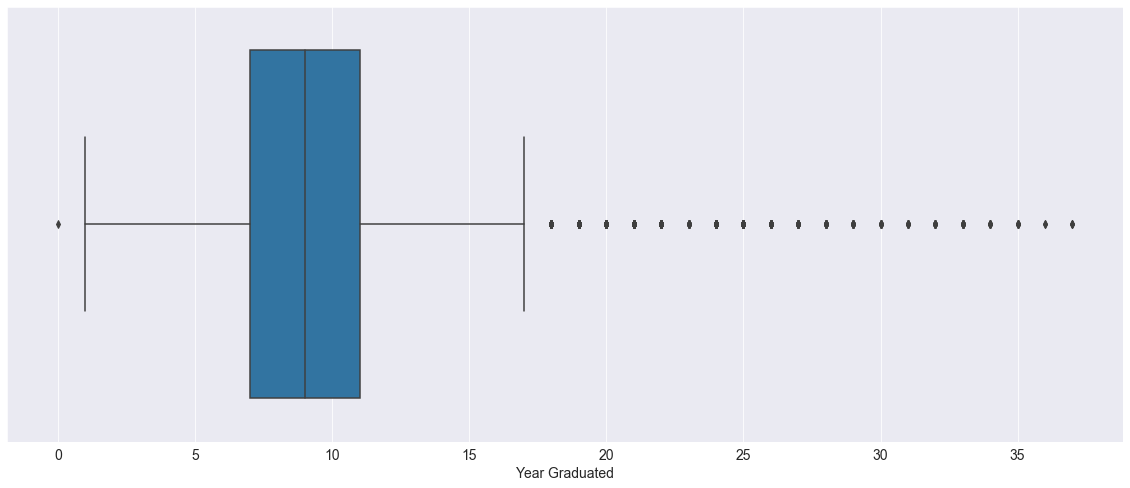

In [400]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x=df["year_graduated"])

plt.xlabel('Year Graduated', fontsize=14);
plt.yticks(fontsize=14);plt.xticks(fontsize=14);

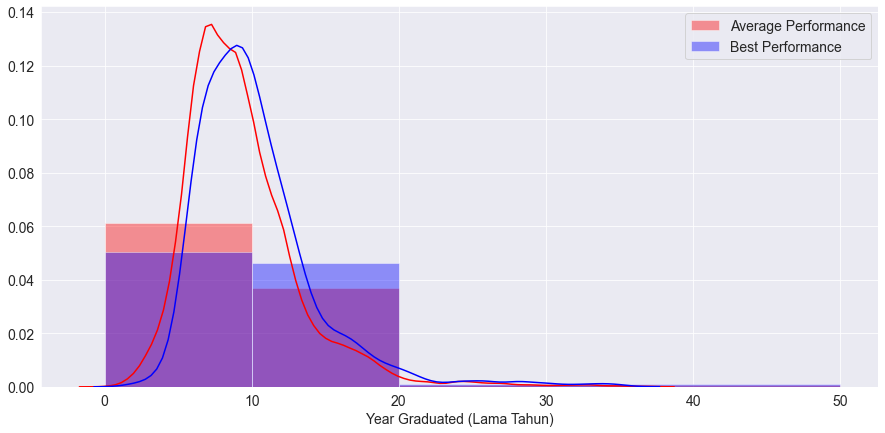

In [401]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 7))
sns.distplot(df.year_graduated[df['Best Performance'] == 0], bins=[0, 10, 20, 50], color="r", label="Average Performance")
sns.distplot(df.year_graduated[df['Best Performance'] == 1], bins=[0, 10, 20, 50], color="b", label="Best Performance")
plt.legend(['Average Performance', 'Best Performance'], fontsize=14)
plt.xlabel('Year Graduated (Lama Tahun)', fontsize=14);
plt.yticks(fontsize=14);plt.xticks(fontsize=14);

<ul>Berdasarkan histogram pada <b>kolom year_graduated</b> tersebut, maka dapat disimpulkan bahwa:
    <li>0-10 tahun dari tahun kelulusan mempunyai kinerja  yg baik</li>
    <li>lebih dari 10 tahun dari tahun kelulusan, mempunyai kinerja yg terbaik (bahkan cenderung lebih produktif), mungkin karena sudah banyak pengalaman</li>
    </ul>

#### Cek Missing Value

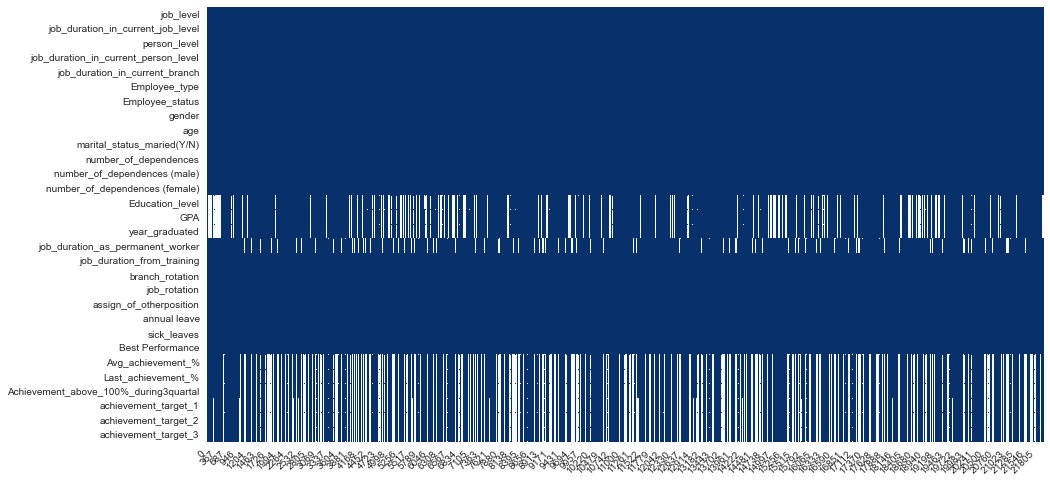

In [402]:
plot_missing_value(df)

#### After handling Missing Value

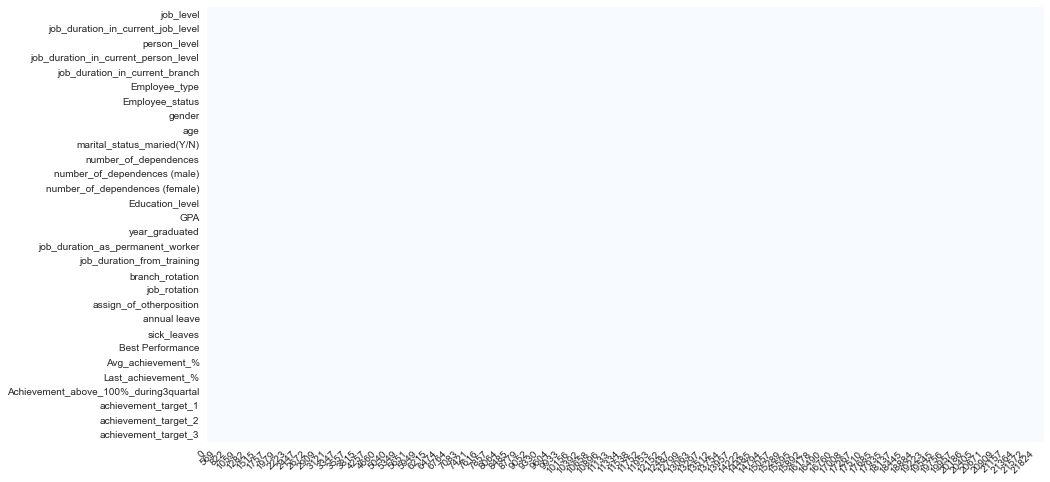

In [403]:
#hapus row NaN
df.dropna(inplace=True)

#setelah drop rows yang missing
plot_missing_value(df)

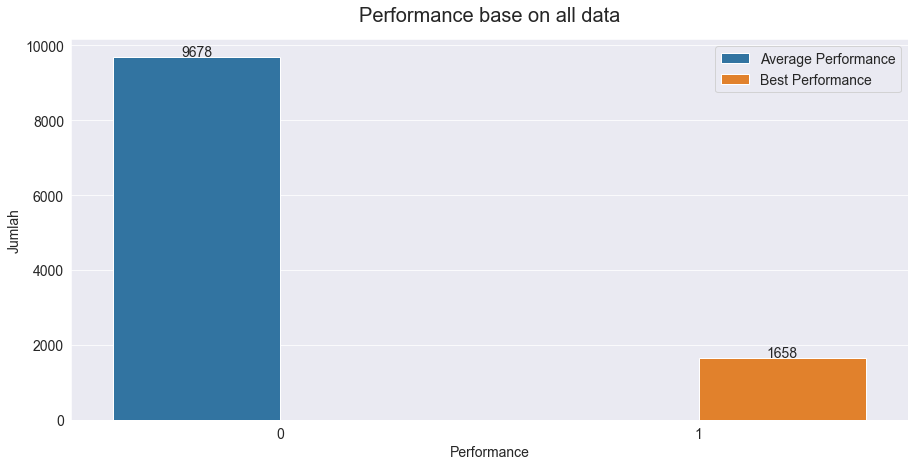

In [404]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 7))
plot = sns.countplot(data=df, x = 'Best Performance', hue =df['Best Performance'])
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points', fontsize=14)
    plt.title('Performance base on all data', fontsize=20, pad=18)
    plt.legend(['Average Performance', 'Best Performance'], fontsize=14)
    plt.xlabel('Performance', fontsize=14); plt.ylabel('Jumlah', fontsize=14);
    plt.yticks(fontsize=14);plt.xticks(fontsize=14)

## Dataset Splitting 

### Standard Splitting

In [44]:
X = df.drop(columns="Best Performance")
y = df['Best Performance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9068, 29), (2268, 29), (9068,), (2268,))

### Smote Sampling

#### Ubah Kategori >> Ordinal 

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# cat_columns = ['job_level','person_level','Employee_type', 'Employee_status', 'gender', 'marital_status_maried(Y/N)', 'Education_level', 'achievement_target_1', 'achievement_target_2', 'achievement_target_3']
# for cat in cat_columns:
#     labelencoder = LabelEncoder()
#     X_train[cat] = labelencoder.fit_transform(X_train[cat].astype(str))
#     X_test[cat] = labelencoder.transform(X_test[cat].astype(str))    

# X_train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
17612,1,2.08,2,2.08,0.08,2,0,1,30,1,0,0,0,3,3.18,8.0,5.0,5,3,3,0,2,0,100.690000,100.92,3.0,1,1,1
16846,1,1.50,2,1.50,0.58,2,0,1,33,1,0,0,0,3,0.00,6.0,3.0,3,3,3,1,2,0,71.030000,71.02,0.0,1,2,1
4823,1,1.75,2,1.75,3.00,1,0,1,31,0,0,0,0,3,3.25,7.0,4.0,4,2,2,2,5,0,58.286667,62.33,0.0,1,2,1
20372,1,2.50,2,2.50,1.50,2,0,1,35,0,0,0,0,3,3.36,12.0,6.0,6,3,3,1,6,0,65.043333,68.34,0.0,0,2,0
12745,1,1.50,2,1.50,1.67,2,0,1,31,0,0,0,0,3,3.00,9.0,5.0,5,2,3,0,3,0,101.470000,104.57,3.0,1,0,1


#### Smote Over Sampling

In [ ]:
# from imblearn.over_sampling import SMOTE

In [ ]:
# print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
# print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

# sm = SMOTE(random_state=42)
# X_train_smote, y_train_smote = sm.fit_resample(X_train.astype('float'), y_train)

# print('After OverSampling, the shape of train_X: {}'.format(X_train_smote.shape))
# print('After OverSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

# print("After OverSampling, counts of label '1': {}".format(sum(y_train_smote==1)))
# print("After OverSampling, counts of label '0': {}".format(sum(y_train_smote==0)))

Before OverSampling, counts of label '1': 1326
Before OverSampling, counts of label '0': 7742 

After OverSampling, the shape of train_X: (15484, 29)
After OverSampling, the shape of train_y: (15484,) 

After OverSampling, counts of label '1': 7742
After OverSampling, counts of label '0': 7742


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# X_train= pd.DataFrame(X_train_smote, columns=X_train.columns)
# X_train.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,1.0,2.08,2.0,2.08,0.08,2.0,0.0,1.0,30.0,1.0,0.0,0.0,0.0,3.0,3.18,8.0,5.0,5.0,3.0,3.0,0.0,2.0,0.0,100.690000,100.92,3.0,1.0,1.0,1.0
1,1.0,1.50,2.0,1.50,0.58,2.0,0.0,1.0,33.0,1.0,0.0,0.0,0.0,3.0,0.00,6.0,3.0,3.0,3.0,3.0,1.0,2.0,0.0,71.030000,71.02,0.0,1.0,2.0,1.0
2,1.0,1.75,2.0,1.75,3.00,1.0,0.0,1.0,31.0,0.0,0.0,0.0,0.0,3.0,3.25,7.0,4.0,4.0,2.0,2.0,2.0,5.0,0.0,58.286667,62.33,0.0,1.0,2.0,1.0
3,1.0,2.50,2.0,2.50,1.50,2.0,0.0,1.0,35.0,0.0,0.0,0.0,0.0,3.0,3.36,12.0,6.0,6.0,3.0,3.0,1.0,6.0,0.0,65.043333,68.34,0.0,0.0,2.0,0.0
4,1.0,1.50,2.0,1.50,1.67,2.0,0.0,1.0,31.0,0.0,0.0,0.0,0.0,3.0,3.00,9.0,5.0,5.0,2.0,3.0,0.0,3.0,0.0,101.470000,104.57,3.0,1.0,0.0,1.0


In [ ]:
# y_train = pd.DataFrame(y_train_smote, columns=['Best Performance'])
# y_train.head()

,Best Performance
0,1
1,1
2,0
3,0
4,0


### Random Up-Sampling

#### Before up sampling

In [ ]:
from sklearn.utils import resample

X = df.drop('Best Performance', axis=1)
y = df['Best Performance']

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
X.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3,Best Performance
16082,2,1.50,3,1.50,1.00,Mantri KUR,Permanent,Male,33,Y,0,0,0,S1,3.22,3.0,3,2,4,0,3,0,83.450000,87.74,2.0,Pencapaian > 1.5,Pencapaian < 50%,not reached,0
10152,2,1.17,3,1.17,0.50,Mantri KUR,Permanent,Male,30,Y,0,0,0,S1,0.00,3.0,3,2,2,0,5,4,76.603333,106.17,1.0,Pencapaian 50%-100%,Pencapaian 100%-150%,reached,0
2669,2,1.83,3,1.83,0.50,Mantri Kupedes,Permanent,Female,34,Y,1,1,0,S1,0.00,4.0,4,3,3,0,2,1,51.593333,58.94,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached,1
20335,2,1.92,3,1.92,3.50,Mantri KUR,Permanent,Male,32,Y,2,1,1,S1,3.18,5.0,5,3,2,0,3,0,66.356667,78.72,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached,0
5320,2,1.17,3,1.17,2.75,Mantri Kupedes,Permanent,Male,39,Y,2,1,1,S1,3.26,3.0,3,1,2,1,0,0,52.986667,46.91,0.0,Pencapaian 50%-100%,Pencapaian < 50%,not reached,0


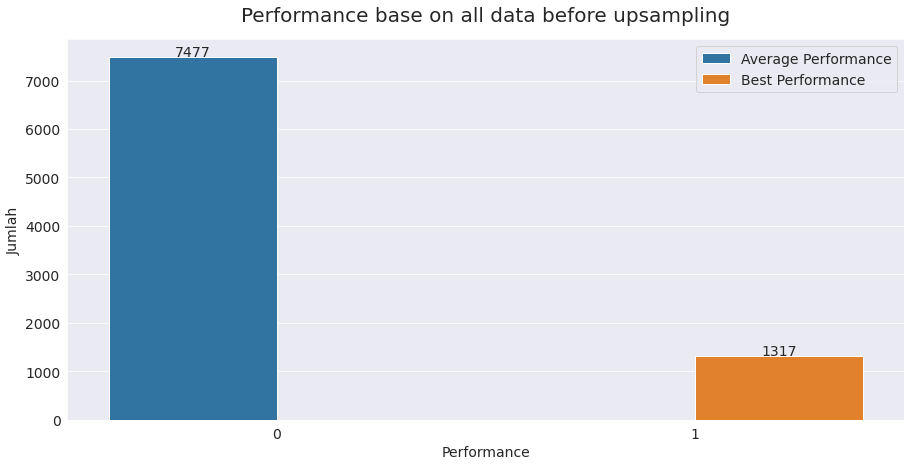

In [ ]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 7))
plot = sns.countplot(data=X, x = 'Best Performance', hue =X['Best Performance'])
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points', fontsize=14)
    plt.title('Performance base on all data before upsampling', fontsize=20, pad=18)
    plt.legend(['Average Performance', 'Best Performance'], fontsize=14)
    plt.xlabel('Performance', fontsize=14); plt.ylabel('Jumlah', fontsize=14);
    plt.yticks(fontsize=14);plt.xticks(fontsize=14)

#### After UpSampling

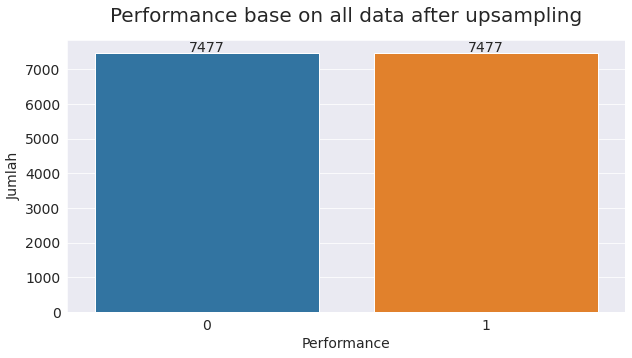

In [ ]:
# separate minority and majority classes
df_majority = X[(X['Best Performance'] == 0)]
df_minority = X[(X['Best Performance'] == 1)]

# upsample minority
df_minority_upsampled  = resample(df_minority,
                          replace=True, # sample with replacement
                          n_samples=len(df_majority), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# check new class counts
sns.set_style(style="darkgrid")
plt.figure(figsize=(10, 5))
plot = sns.countplot(x=df_upsampled['Best Performance'], data=df_upsampled)
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points', fontsize=14)
    plt.title('Performance base on all data after upsampling', fontsize=20, pad=18)
#     plt.legend(['Average Performance', 'Best Performance'], fontsize=14, loc="upper left")
    plt.xlabel('Performance', fontsize=14); plt.ylabel('Jumlah', fontsize=14);
    plt.yticks(fontsize=14);plt.xticks(fontsize=14)

In [ ]:
# trying XGBoost again with the balanced dataset
X_train = df_upsampled.drop('Best Performance', axis=1)
y_train = df_upsampled['Best Performance']

## Training

### Think Simple[1]

In [80]:
#preprocessing
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), ['job_duration_in_current_job_level',
                                             'job_duration_in_current_person_level',
                                             'job_duration_in_current_branch',
                                             'age','number_of_dependences',
                                             'number_of_dependences (male)', 'number_of_dependences (female)',
                                             'GPA', 'year_graduated','job_duration_as_permanent_worker', 
                                             'job_duration_from_training','branch_rotation', 'job_rotation', 
                                             'assign_of_otherposition','annual leave', 'sick_leaves', 
                                             'Avg_achievement_%','Last_achievement_%',
                                             'Achievement_above_100%_during3quartal']),
                                  
    ('categoric', cat_pipe(impute='most_frequent', encoder='onehot'), ['job_level','person_level','Employee_type', 'Employee_status', 
                                       'gender', 'marital_status_maried(Y/N)','Education_level', 
                                       'achievement_target_1', 'achievement_target_2', 'achievement_target_3']),
])

#imbalance datset_class_weight
weight = (y_train.value_counts()[0]/y_train.value_counts()[1])

#pipeline
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(random_state=42, scale_pos_weight=weight))
])

#model - fine tuning
model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=10, scoring='roc_auc', n_jobs=-1, verbose=1 )
model.fit(X_train, y_train)

#report
print(model.best_params_)
print(model.score(X_train, y_train), model.score(X_test, y_test))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished


{'algo__colsample_bytree': 0.5718204701559528, 'algo__gamma': 3, 'algo__learning_rate': 0.02077017873317677, 'algo__max_depth': 3, 'algo__n_estimators': 172, 'algo__reg_alpha': 0.002560322647881277, 'algo__reg_lambda': 1.780319470760321, 'algo__subsample': 0.5953415692602614}
0.6888808590622226 0.5817547047694912


#### Evaluasi

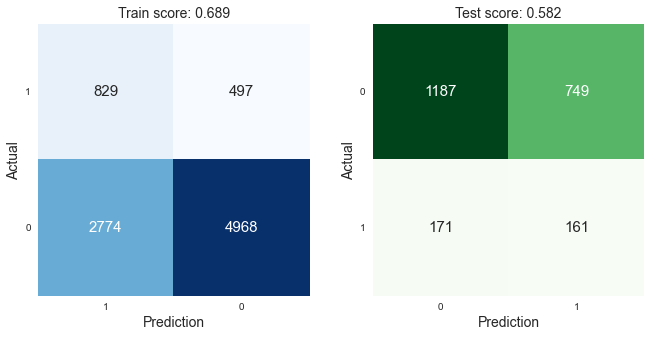

In [82]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

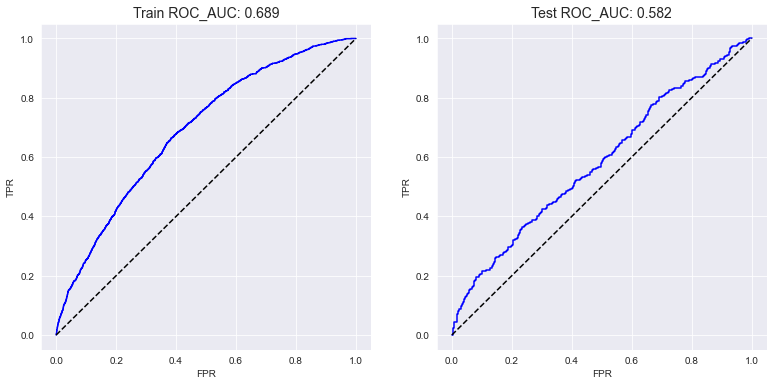

In [290]:
plot_roc_curve(X_train, y_train, X_test, y_test, model)

In [84]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       0.91      0.64      0.75      7742
           1       0.23      0.63      0.34      1326

    accuracy                           0.64      9068
   macro avg       0.57      0.63      0.54      9068
weighted avg       0.81      0.64      0.69      9068


Test report
              precision    recall  f1-score   support

           0       0.87      0.61      0.72      1936
           1       0.18      0.48      0.26       332

    accuracy                           0.59      2268
   macro avg       0.53      0.55      0.49      2268
weighted avg       0.77      0.59      0.65      2268



#### Save Model

In [292]:
save_model(model.best_estimator_, "IK-AILAB_P1____XGBv1.pkl")

### Think Simple[2]

In [335]:
#preprocessing
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', poly=2), ['job_duration_in_current_job_level',
                                             'job_duration_in_current_person_level',
                                             'job_duration_in_current_branch',
                                             'age','number_of_dependences',
                                             'number_of_dependences (male)', 'number_of_dependences (female)',
                                             'GPA', 'year_graduated','job_duration_as_permanent_worker', 
                                             'job_duration_from_training','branch_rotation', 'job_rotation', 
                                             'assign_of_otherposition','annual leave', 'sick_leaves', 
                                             'Avg_achievement_%','Last_achievement_%',
                                             'Achievement_above_100%_during3quartal']),
                                  
    ('categoric', cat_pipe(impute='most_frequent', encoder='onehot'), ['job_level','person_level','Employee_type', 'Employee_status', 
                                       'gender', 'marital_status_maried(Y/N)','Education_level', 
                                       'achievement_target_1', 'achievement_target_2', 'achievement_target_3']),
])

#imbalance dataset_class_weight
weight = (y_train.value_counts()[0]/y_train.value_counts()[1])

#pipeline
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(random_state=42, scale_pos_weight=weight))
])

#model - fine tuning
model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=10, scoring='roc_auc', n_jobs=-1, verbose=1 )
model.fit(X_train, y_train)

#report
print(model.best_params_)
print(model.score(X_train, y_train), model.score(X_test, y_test))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 31.9min finished


{'algo__colsample_bytree': 0.536035724767811, 'algo__gamma': 9, 'algo__learning_rate': 0.010087466671819242, 'algo__max_depth': 2, 'algo__n_estimators': 135, 'algo__reg_alpha': 0.24874476048831196, 'algo__reg_lambda': 0.09554147966144805, 'algo__subsample': 0.6462045121237484, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': True}
0.6563485666905516 0.6011424312954297


#### Evaluasi

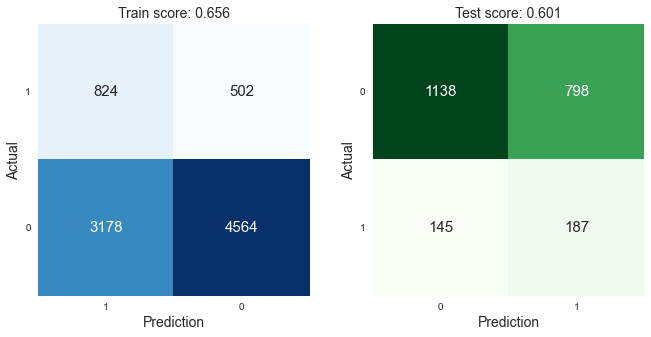

In [337]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

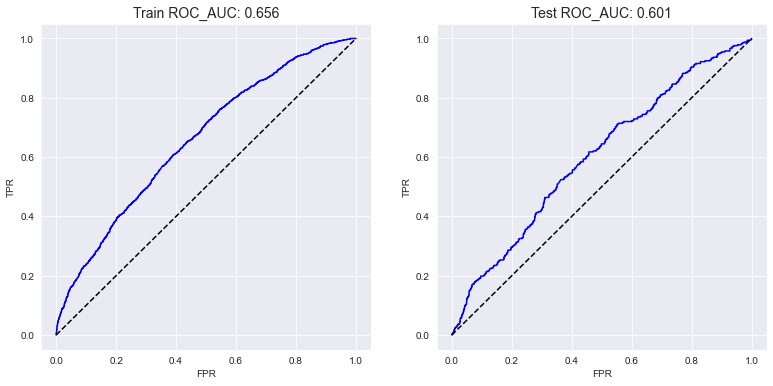

In [338]:
plot_roc_curve(X_train, y_train, X_test, y_test, model)

In [339]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       0.90      0.59      0.71      7742
           1       0.21      0.62      0.31      1326

    accuracy                           0.59      9068
   macro avg       0.55      0.61      0.51      9068
weighted avg       0.80      0.59      0.65      9068


Test report
              precision    recall  f1-score   support

           0       0.89      0.59      0.71      1936
           1       0.19      0.56      0.28       332

    accuracy                           0.58      2268
   macro avg       0.54      0.58      0.50      2268
weighted avg       0.78      0.58      0.65      2268



#### Save Model

In [340]:
save_model(model.best_estimator_, "IK-AILAB_P1____XGBv7.pkl")

Model is pickled as model/IK-AILAB_P1____XGBv7.pkl


### Feature Importance [10 Feature teratas][1]
melihat apa saja fitur yang penting? dan itu bisa meng-cut fitur agar tdk terlalu banyak

In [349]:
from jcopml.utils import load_model
model = load_model("../notebook/model/IK-AILAB_P1____XGBv1.pkl")

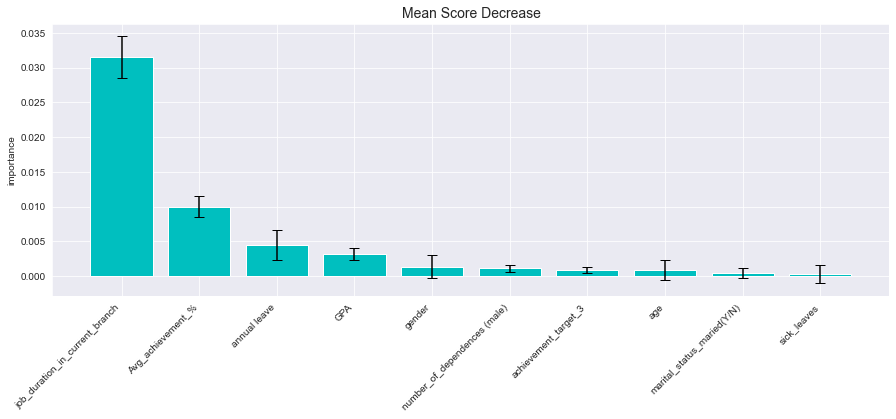

In [307]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

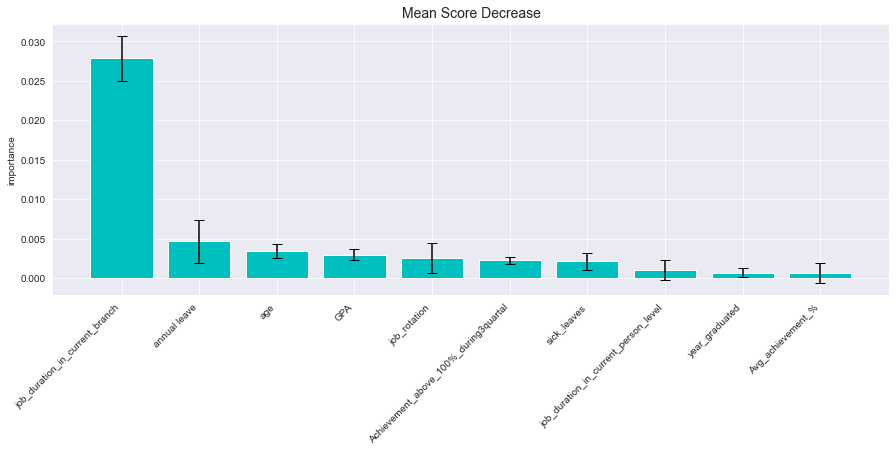

In [350]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

In [112]:
list(df_imp.feature[:10])

['job_duration_in_current_branch',
 'Avg_achievement_%',
 'annual leave',
 'GPA',
 'gender',
 'number_of_dependences (male)',
 'achievement_target_3',
 'age',
 'marital_status_maried(Y/N)',
 'sick_leaves']

<b>"setelah kita menemukan fitur mana yg penting, maka akan dilakukan seleksi terhadap semua fitur yg akan digunakan"<b>

In [152]:
#preprocessing
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', poly=2), ['job_duration_in_current_branch',
                                                 'Avg_achievement_%',
                                                 'annual leave',
                                                 'GPA',
                                                 'number_of_dependences (male)',
                                                 'age',
                                                 'sick_leaves']),
                                  
    ('categoric', cat_pipe(impute='most_frequent', encoder='onehot'), ['gender',
                                                                       'achievement_target_3',
                                                                       'marital_status_maried(Y/N)']),
])

#imbalanced dataset_class weight
weight = (y_train.value_counts()[0]/y_train.value_counts()[1])

#pipeline
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(random_state=42, scale_pos_weight=weight))
])

#model- fine tuning
model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=10, scoring='roc_auc', n_jobs=-1, verbose=1 )
model.fit(X_train, y_train)

#report
print(model.best_params_)
print(model.score(X_train, y_train), model.score(X_test, y_test))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished


{'algo__colsample_bytree': 0.7843453951994243, 'algo__gamma': 7, 'algo__learning_rate': 0.015200106204020283, 'algo__max_depth': 3, 'algo__n_estimators': 162, 'algo__reg_alpha': 5.174732916288006, 'algo__reg_lambda': 0.00251631532867959, 'algo__subsample': 0.6125053539592495, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.6780526231914382 0.5901506335258389


#### Evaluasi

##### Confusion Matrix

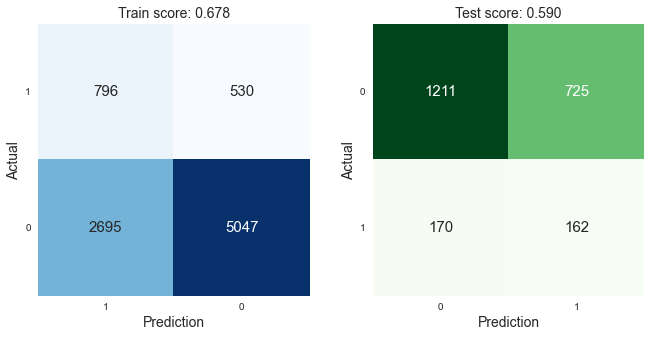

In [153]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

##### Luas Daerah ROC

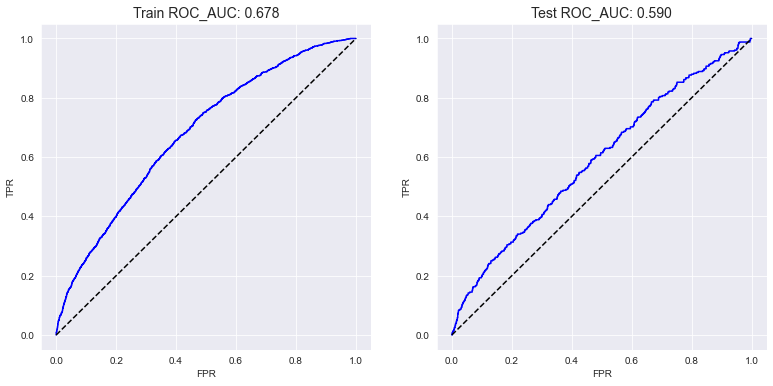

In [154]:
plot_roc_curve(X_train, y_train, X_test, y_test, model)

##### Classification Report

In [155]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       0.90      0.65      0.76      7742
           1       0.23      0.60      0.33      1326

    accuracy                           0.64      9068
   macro avg       0.57      0.63      0.54      9068
weighted avg       0.81      0.64      0.70      9068


Test report
              precision    recall  f1-score   support

           0       0.88      0.63      0.73      1936
           1       0.18      0.49      0.27       332

    accuracy                           0.61      2268
   macro avg       0.53      0.56      0.50      2268
weighted avg       0.78      0.61      0.66      2268



##### Save Model

In [156]:
save_model(model.best_estimator_, "IK-AILAB_P1____XGBv3.pkl")

Model is pickled as model/IK-AILAB_P1____XGBv3.pkl


### Feature Importance [10 Feature teratas][2]
melihat apa saja fitur yang penting? dan itu bisa meng-cut fitur agar tdk terlalu banyak

In [86]:
from jcopml.utils import load_model
model = load_model("../notebook/model/IK-AILAB_P1____XGBv7.pkl")

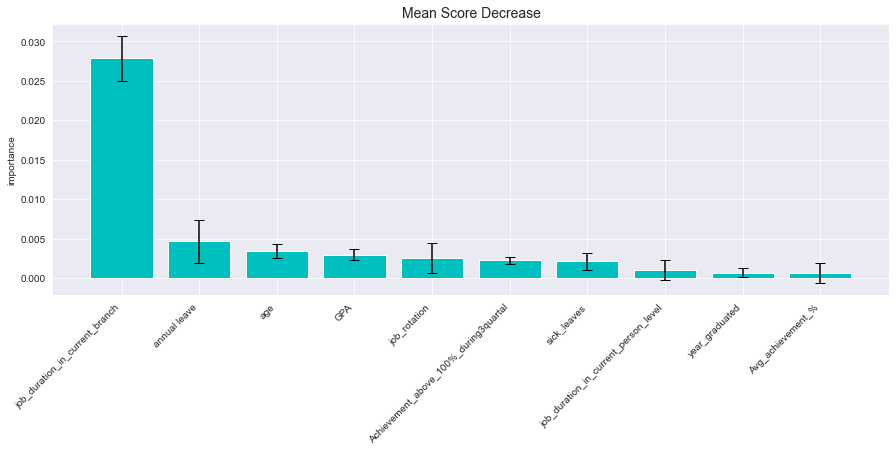

In [87]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

In [49]:
list(df_imp.feature[:10])

['job_duration_in_current_branch',
 'annual leave',
 'age',
 'GPA',
 'job_rotation',
 'Achievement_above_100%_during3quartal',
 'sick_leaves',
 'job_duration_in_current_person_level',
 'year_graduated',
 'Avg_achievement_%']

<b>"setelah kita menemukan fitur mana yg penting, maka akan dilakukan seleksi terhadap semua fitur yg akan digunakan"<b>

#### Feature Engineering - 2

##### Binning Year Graduated Variabel

In [432]:
df['year_graduated'].max()

37.0

In [440]:
df = df.copy()
df['year_graduated'] = pd.cut(df['year_graduated'], [-1, 10, 20, 50], labels=["FreshGraduated", "Cukup Lama", "Sangat Lama"])
df.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Best Performance,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,8.00,PG06,8.00,0.50,Mantri Kupedes,Permanent,Female,Dewasa3,Y,3,1,2,S1,2.32,Sangat Lama,30.0,30,9,7,0,Cukup,0,0,68.850000,72.53,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
1,JG04,5.17,PG04,2.00,1.25,Mantri Kupedes,Permanent,Male,Dewasa2,Y,3,2,1,S1,3.25,Cukup Lama,15.0,16,7,7,9,Sedikit,0,0,94.810000,101.13,3.0,Pencapaian 50%-100%,Pencapaian 50%-100%,reached
2,JG04,1.83,PG03,1.83,1.50,Mantri Kupedes,Permanent,Male,Dewasa2,Y,1,0,1,S2,3.23,Cukup Lama,15.0,15,9,9,0,Cukup,0,0,72.820000,71.30,0.0,Pencapaian 100%-150%,Pencapaian < 50%,not reached
3,JG04,7.92,PG04,4.00,0.17,Mantri Kupedes,Permanent,Male,Dewasa2,Y,0,0,0,D3/D4,0.00,Cukup Lama,8.0,8,5,5,0,Sedikit,0,0,86.890000,90.09,2.0,Pencapaian 50%-100%,Pencapaian 50%-100%,not reached
6,JG04,1.75,PG03,1.75,1.33,Mantri KUR,Permanent,Female,Dewasa1,N,0,0,0,S1,3.65,Cukup Lama,6.0,6,7,5,0,Sedikit,2,1,66.816667,70.43,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached


##### Binning Annual Leave Variabel

In [405]:
df['annual leave'].unique()

array([ 8,  3,  6,  0,  5,  2,  4, 15,  1, 10,  7,  9, 14, 12, 18, 13, 11,
       17, 16, 20, 21], dtype=int64)

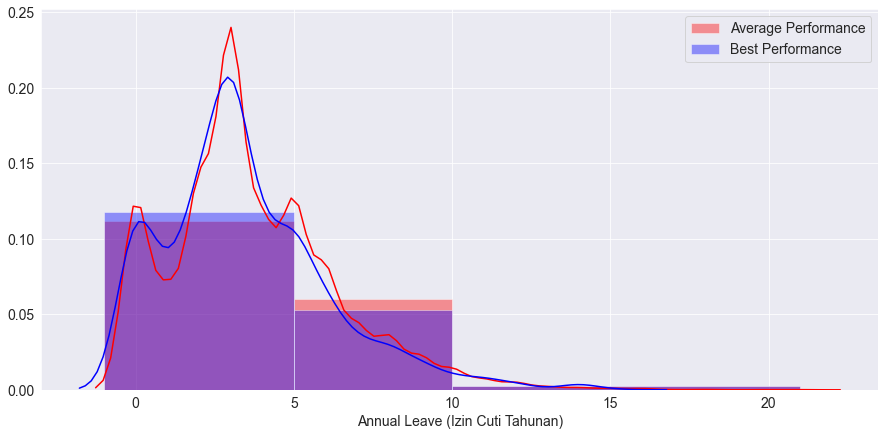

In [412]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(15, 7))
sns.distplot(df['annual leave'][df['Best Performance'] == 0], bins=[-1, 5, 10, 21], color="r", label="Average Performance")
sns.distplot(df['annual leave'][df['Best Performance'] == 1], bins=[-1, 5, 10, 21], color="b", label="Best Performance")
plt.legend(['Average Performance', 'Best Performance'], fontsize=14)
plt.xlabel('Annual Leave (Izin Cuti Tahunan)', fontsize=14);
plt.yticks(fontsize=14);plt.xticks(fontsize=14);

In [413]:
df = df.copy()
df['annual leave'] = pd.cut(df['annual leave'], [-1, 5, 10, 21], labels=["Sedikit", "Cukup", "Sering"])
df.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Best Performance,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,8.00,PG06,8.00,0.50,Mantri Kupedes,Permanent,Female,56,Y,3,1,2,S1,2.32,33.0,30.0,30,9,7,0,Cukup,0,0,68.850000,72.53,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
1,JG04,5.17,PG04,2.00,1.25,Mantri Kupedes,Permanent,Male,41,Y,3,2,1,S1,3.25,19.0,15.0,16,7,7,9,Sedikit,0,0,94.810000,101.13,3.0,Pencapaian 50%-100%,Pencapaian 50%-100%,reached
2,JG04,1.83,PG03,1.83,1.50,Mantri Kupedes,Permanent,Male,40,Y,1,0,1,S2,3.23,13.0,15.0,15,9,9,0,Cukup,0,0,72.820000,71.30,0.0,Pencapaian 100%-150%,Pencapaian < 50%,not reached
3,JG04,7.92,PG04,4.00,0.17,Mantri Kupedes,Permanent,Male,36,Y,0,0,0,D3/D4,0.00,14.0,8.0,8,5,5,0,Sedikit,0,0,86.890000,90.09,2.0,Pencapaian 50%-100%,Pencapaian 50%-100%,not reached
6,JG04,1.75,PG03,1.75,1.33,Mantri KUR,Permanent,Female,34,N,0,0,0,S1,3.65,12.0,6.0,6,7,5,0,Sedikit,2,1,66.816667,70.43,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached


##### Binning age variabel

In [422]:
df['age'].unique()

array([56, 41, 40, 36, 34, 33, 32, 31, 30, 29, 51, 50, 35, 37, 45, 49, 46,
       52, 38, 55, 43, 39, 28, 47, 27, 48, 42, 26, 44, 57, 54, 23, 53, 25,
       24], dtype=int64)

In [423]:
df = df.copy()
df['age'] = pd.cut(df['age'], [20, 34, 45, 65], labels=["Dewasa1", "Dewasa2", "Dewasa3"])
df.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Best Performance,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,8.00,PG06,8.00,0.50,Mantri Kupedes,Permanent,Female,Dewasa3,Y,3,1,2,S1,2.32,33.0,30.0,30,9,7,0,Cukup,0,0,68.850000,72.53,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
1,JG04,5.17,PG04,2.00,1.25,Mantri Kupedes,Permanent,Male,Dewasa2,Y,3,2,1,S1,3.25,19.0,15.0,16,7,7,9,Sedikit,0,0,94.810000,101.13,3.0,Pencapaian 50%-100%,Pencapaian 50%-100%,reached
2,JG04,1.83,PG03,1.83,1.50,Mantri Kupedes,Permanent,Male,Dewasa2,Y,1,0,1,S2,3.23,13.0,15.0,15,9,9,0,Cukup,0,0,72.820000,71.30,0.0,Pencapaian 100%-150%,Pencapaian < 50%,not reached
3,JG04,7.92,PG04,4.00,0.17,Mantri Kupedes,Permanent,Male,Dewasa2,Y,0,0,0,D3/D4,0.00,14.0,8.0,8,5,5,0,Sedikit,0,0,86.890000,90.09,2.0,Pencapaian 50%-100%,Pencapaian 50%-100%,not reached
6,JG04,1.75,PG03,1.75,1.33,Mantri KUR,Permanent,Female,Dewasa1,N,0,0,0,S1,3.65,12.0,6.0,6,7,5,0,Sedikit,2,1,66.816667,70.43,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached


#### Cek Miss Value

,missing_value,%
job_level,0,0.0
job_duration_in_current_job_level,0,0.0
person_level,0,0.0
job_duration_in_current_person_level,0,0.0
job_duration_in_current_branch,0,0.0
Employee_type,0,0.0
Employee_status,0,0.0
gender,0,0.0
age,0,0.0
marital_status_maried(Y/N),0,0.0


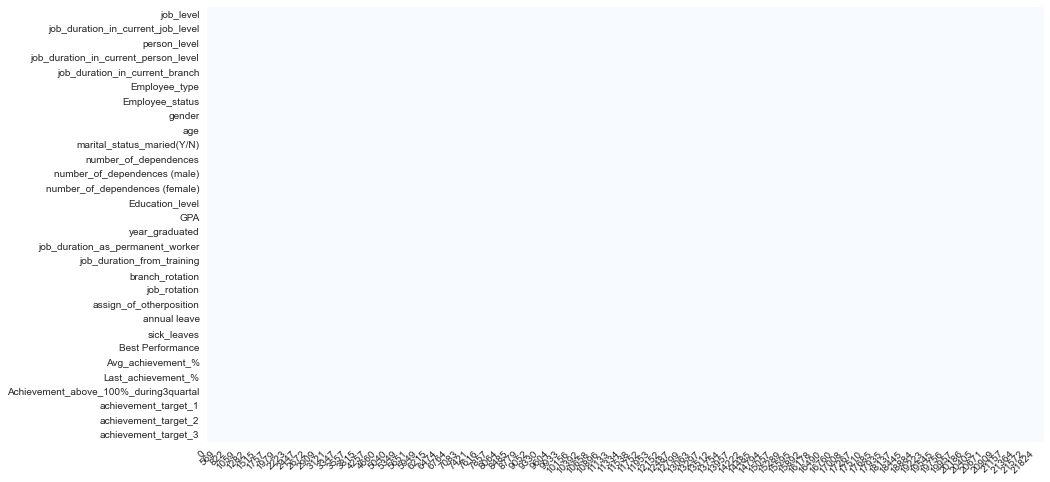

In [441]:
plot_missing_value(df, return_df=True)

#### Dataset Splitting - 2

In [442]:
X = df.drop(columns="Best Performance")
y = df['Best Performance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9068, 29), (2268, 29), (9068,), (2268,))

#### Training

In [ ]:
#preprocessing
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', poly=2), 
                                         ['job_duration_in_current_branch',
                                         'GPA',
                                         'Achievement_above_100%_during3quartal',
                                         'sick_leaves',
                                         'job_duration_in_current_person_level',
                                         'Avg_achievement_%',
                                         'job_rotation'
                                         ]),
    
    ('categoric', cat_pipe(encoder='ordinal'), ['age','annual leave','year_graduated'])
])

#imbalanced dataset_class weight
weight = (y_train.value_counts()[0]/y_train.value_counts()[1]) 

#pipeline
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(random_state=42, scale_pos_weight=weight))
])

#model- fine tuning
model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=10, scoring='roc_auc', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

#report
print(model.best_params_)
print(model.score(X_train, y_train), model.score(X_test, y_test))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.1min


#### Evaluasi

##### Confusion Matrix

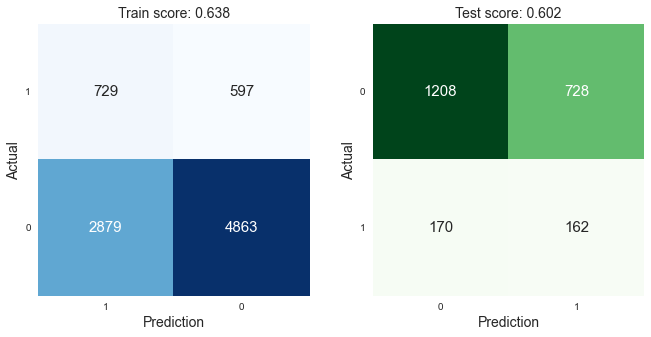

In [585]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

##### Luas Daerah ROC

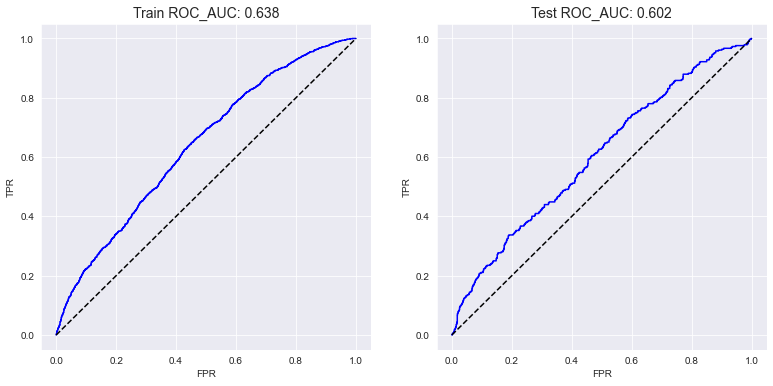

In [586]:
plot_roc_curve(X_train, y_train, X_test, y_test, model)

##### Classification Report

In [587]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       0.89      0.63      0.74      7742
           1       0.20      0.55      0.30      1326

    accuracy                           0.62      9068
   macro avg       0.55      0.59      0.52      9068
weighted avg       0.79      0.62      0.67      9068


Test report
              precision    recall  f1-score   support

           0       0.88      0.62      0.73      1936
           1       0.18      0.49      0.27       332

    accuracy                           0.60      2268
   macro avg       0.53      0.56      0.50      2268
weighted avg       0.77      0.60      0.66      2268



##### Save Model

In [588]:
save_model(model.best_estimator_, "IK-AILAB_P1____XGBv9.pkl")

Model is pickled as model/IK-AILAB_P1____XGBv9.pkl


## Submission

###  Import Data Testing

In [59]:
test = pd.read_csv("../data/bri-data-hackathon-people-analytic/test.csv")
test.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,1.42,PG05,1.42,0.5,RM_type_C,Permanent,Female,1983,Y,2,1,1,level_3,3.75,2004,13.0,14,7,9,1,3,1,79.506667,94.17,1.0,achiev_50%-100%,achiev_< 50%,reached
1,JG04,1.58,PG03,1.58,2.0,RM_type_A,Permanent,Male,1988,N,0,0,0,level_4,3.07,2011,4.0,4,2,2,2,4,1,54.283333,42.97,0.0,Pencapaian < 50%,Pencapaian < 50%,reached
2,JG04,1.83,PG03,1.83,1.5,RM_type_A,Permanent,Male,1988,Y,1,0,1,level_4,3.23,2011,4.0,4,3,2,0,2,0,43.016667,44.28,0.0,achiev_50%-100%,achiev_< 50%,reached
3,JG05,8.00,PG06,5.00,1.5,RM_type_A,Permanent,Male,1973,Y,3,2,1,level_4,0.00,\N,22.0,22,8,5,11,3,0,74.390000,80.93,0.0,Pencapaian 50%-100%,Pencapaian < 50%,not reached
4,JG04,1.92,PG03,1.92,0.5,RM_type_A,Permanent,Female,1985,Y,1,1,0,level_3,3.86,2008,6.0,6,6,3,0,3,0,106.376667,109.09,3.0,Pencapaian 50%-100%,Pencapaian > 1.5,reached


### Year Graduated >> Jadikan lama tahun kelulusan

In [60]:
# digantikan dgn nilai modus = 2011 (outlier)
test=test.copy()
test.replace({'2004':2004, '2011':2011, '\\N':2011, '2008':2008, '1999':1999, '2006':2006, '2015':2015, '2014':2014,
       '2010':2010, '9999':2011, '2012':2012, '2009':2009, '2003':2003, '2007':2007, '2005':2005, '2013':2013,
       '207':2011, '0':2011, '1998':1998, '3.05':2011, '2002':2002, '1989':1989, '2016':2016, '3.18':2011, '2001':2001,
       '2201':2011, '2000':2000, '1993':1993, '1992':1992, '1990':1990, '1995':1995, '1996':1996, '2999':2011,
       '2018':2018, '1997':1997, '209':2011, '1994':1994, '1991':1991, '1016':2011, '1986':1986, '2017':2017,
       '1982':1982, '1984':1984, '1988':1988, '2019':2019, '1983':1983, '1985':1985, '1987':1987, '.':2011,
       '3013':2011}, inplace=True)
test.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,1.42,PG05,1.42,0.5,RM_type_C,Permanent,Female,1983,Y,2,1,1,level_3,3.75,2004,13.0,14,7,9,1,3,1,79.506667,94.17,1.0,achiev_50%-100%,achiev_< 50%,reached
1,JG04,1.58,PG03,1.58,2.0,RM_type_A,Permanent,Male,1988,N,0,0,0,level_4,3.07,2011,4.0,4,2,2,2,4,1,54.283333,42.97,0.0,Pencapaian < 50%,Pencapaian < 50%,reached
2,JG04,1.83,PG03,1.83,1.5,RM_type_A,Permanent,Male,1988,Y,1,0,1,level_4,3.23,2011,4.0,4,3,2,0,2,0,43.016667,44.28,0.0,achiev_50%-100%,achiev_< 50%,reached
3,JG05,8.00,PG06,5.00,1.5,RM_type_A,Permanent,Male,1973,Y,3,2,1,level_4,0.00,2011,22.0,22,8,5,11,3,0,74.390000,80.93,0.0,Pencapaian 50%-100%,Pencapaian < 50%,not reached
4,JG04,1.92,PG03,1.92,0.5,RM_type_A,Permanent,Female,1985,Y,1,1,0,level_3,3.86,2008,6.0,6,6,3,0,3,0,106.376667,109.09,3.0,Pencapaian 50%-100%,Pencapaian > 1.5,reached


In [61]:
test = test.copy()
test['year_graduated'] = 2020 - test['year_graduated']
test.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,1.42,PG05,1.42,0.5,RM_type_C,Permanent,Female,1983,Y,2,1,1,level_3,3.75,16,13.0,14,7,9,1,3,1,79.506667,94.17,1.0,achiev_50%-100%,achiev_< 50%,reached
1,JG04,1.58,PG03,1.58,2.0,RM_type_A,Permanent,Male,1988,N,0,0,0,level_4,3.07,9,4.0,4,2,2,2,4,1,54.283333,42.97,0.0,Pencapaian < 50%,Pencapaian < 50%,reached
2,JG04,1.83,PG03,1.83,1.5,RM_type_A,Permanent,Male,1988,Y,1,0,1,level_4,3.23,9,4.0,4,3,2,0,2,0,43.016667,44.28,0.0,achiev_50%-100%,achiev_< 50%,reached
3,JG05,8.00,PG06,5.00,1.5,RM_type_A,Permanent,Male,1973,Y,3,2,1,level_4,0.00,9,22.0,22,8,5,11,3,0,74.390000,80.93,0.0,Pencapaian 50%-100%,Pencapaian < 50%,not reached
4,JG04,1.92,PG03,1.92,0.5,RM_type_A,Permanent,Female,1985,Y,1,1,0,level_3,3.86,12,6.0,6,6,3,0,3,0,106.376667,109.09,3.0,Pencapaian 50%-100%,Pencapaian > 1.5,reached


### achievement_target_1_2_3

In [62]:
test = test.copy()
test['achievement_target_1'] = test['achievement_target_1'].apply({"achiev_50%-100%":"Pencapaian 50%-100%",
                                                                       "achiev_100%-150%":"Pencapaian 100%-150%",
                                                                       "achiev_< 50%":"Pencapaian < 50%",
                                                                       "achiev_> 1.5":"Pencapaian > 1.5",
                                                                       "Tidak diberikan target":"Tidak diberikan target",
                                                                       "Pencapaian 50%-100%":"Pencapaian 50%-100%",
                                                                       "Pencapaian < 50%":"Pencapaian < 50%",
                                                                       "Pencapaian 100%-150%":"Pencapaian 100%-150%",
                                                                       "Pencapaian > 1.5":"Pencapaian > 1.5"}.get)
test.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,1.42,PG05,1.42,0.5,RM_type_C,Permanent,Female,1983,Y,2,1,1,level_3,3.75,16,13.0,14,7,9,1,3,1,79.506667,94.17,1.0,Pencapaian 50%-100%,achiev_< 50%,reached
1,JG04,1.58,PG03,1.58,2.0,RM_type_A,Permanent,Male,1988,N,0,0,0,level_4,3.07,9,4.0,4,2,2,2,4,1,54.283333,42.97,0.0,Pencapaian < 50%,Pencapaian < 50%,reached
2,JG04,1.83,PG03,1.83,1.5,RM_type_A,Permanent,Male,1988,Y,1,0,1,level_4,3.23,9,4.0,4,3,2,0,2,0,43.016667,44.28,0.0,Pencapaian 50%-100%,achiev_< 50%,reached
3,JG05,8.00,PG06,5.00,1.5,RM_type_A,Permanent,Male,1973,Y,3,2,1,level_4,0.00,9,22.0,22,8,5,11,3,0,74.390000,80.93,0.0,Pencapaian 50%-100%,Pencapaian < 50%,not reached
4,JG04,1.92,PG03,1.92,0.5,RM_type_A,Permanent,Female,1985,Y,1,1,0,level_3,3.86,12,6.0,6,6,3,0,3,0,106.376667,109.09,3.0,Pencapaian 50%-100%,Pencapaian > 1.5,reached


In [63]:
test = test.copy()
test['achievement_target_2'] = test['achievement_target_2'].apply({"achiev_50%-100%":"Pencapaian 50%-100%",
                                                                       "achiev_100%-150%":"Pencapaian 100%-150%",
                                                                       "achiev_< 50%":"Pencapaian < 50%",
                                                                       "achiev_> 1.5":"Pencapaian > 1.5",
                                                                       "Tidak diberikan target":"Tidak diberikan target",
                                                                       "Pencapaian 50%-100%":"Pencapaian 50%-100%",
                                                                       "Pencapaian < 50%":"Pencapaian < 50%",
                                                                       "Pencapaian 100%-150%":"Pencapaian 100%-150%",
                                                                       "Pencapaian > 1.5":"Pencapaian > 1.5"}.get)
test.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,1.42,PG05,1.42,0.5,RM_type_C,Permanent,Female,1983,Y,2,1,1,level_3,3.75,16,13.0,14,7,9,1,3,1,79.506667,94.17,1.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
1,JG04,1.58,PG03,1.58,2.0,RM_type_A,Permanent,Male,1988,N,0,0,0,level_4,3.07,9,4.0,4,2,2,2,4,1,54.283333,42.97,0.0,Pencapaian < 50%,Pencapaian < 50%,reached
2,JG04,1.83,PG03,1.83,1.5,RM_type_A,Permanent,Male,1988,Y,1,0,1,level_4,3.23,9,4.0,4,3,2,0,2,0,43.016667,44.28,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
3,JG05,8.00,PG06,5.00,1.5,RM_type_A,Permanent,Male,1973,Y,3,2,1,level_4,0.00,9,22.0,22,8,5,11,3,0,74.390000,80.93,0.0,Pencapaian 50%-100%,Pencapaian < 50%,not reached
4,JG04,1.92,PG03,1.92,0.5,RM_type_A,Permanent,Female,1985,Y,1,1,0,level_3,3.86,12,6.0,6,6,3,0,3,0,106.376667,109.09,3.0,Pencapaian 50%-100%,Pencapaian > 1.5,reached


In [64]:
test = test.copy()
test['achievement_target_3'] = test['achievement_target_3'].map({"not_reached":"not reached","reached":"reached","not reached":"not reached"})
test.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,1.42,PG05,1.42,0.5,RM_type_C,Permanent,Female,1983,Y,2,1,1,level_3,3.75,16,13.0,14,7,9,1,3,1,79.506667,94.17,1.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
1,JG04,1.58,PG03,1.58,2.0,RM_type_A,Permanent,Male,1988,N,0,0,0,level_4,3.07,9,4.0,4,2,2,2,4,1,54.283333,42.97,0.0,Pencapaian < 50%,Pencapaian < 50%,reached
2,JG04,1.83,PG03,1.83,1.5,RM_type_A,Permanent,Male,1988,Y,1,0,1,level_4,3.23,9,4.0,4,3,2,0,2,0,43.016667,44.28,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
3,JG05,8.00,PG06,5.00,1.5,RM_type_A,Permanent,Male,1973,Y,3,2,1,level_4,0.00,9,22.0,22,8,5,11,3,0,74.390000,80.93,0.0,Pencapaian 50%-100%,Pencapaian < 50%,not reached
4,JG04,1.92,PG03,1.92,0.5,RM_type_A,Permanent,Female,1985,Y,1,1,0,level_3,3.86,12,6.0,6,6,3,0,3,0,106.376667,109.09,3.0,Pencapaian 50%-100%,Pencapaian > 1.5,reached


### Educational Level

In [65]:
#Merubah Value Employee Type
test = test.copy()
test['Education_level'] = test['Education_level'].apply({'level_0': 'Internal course',
                       'level_1': 'SLTA',
                       'level_2': 'D1',
                       'level_3': 'D3/D4',
                       'level_4': 'S1',
                       'level_5': 'S2'}.get)
test.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,1.42,PG05,1.42,0.5,RM_type_C,Permanent,Female,1983,Y,2,1,1,D3/D4,3.75,16,13.0,14,7,9,1,3,1,79.506667,94.17,1.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
1,JG04,1.58,PG03,1.58,2.0,RM_type_A,Permanent,Male,1988,N,0,0,0,S1,3.07,9,4.0,4,2,2,2,4,1,54.283333,42.97,0.0,Pencapaian < 50%,Pencapaian < 50%,reached
2,JG04,1.83,PG03,1.83,1.5,RM_type_A,Permanent,Male,1988,Y,1,0,1,S1,3.23,9,4.0,4,3,2,0,2,0,43.016667,44.28,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
3,JG05,8.00,PG06,5.00,1.5,RM_type_A,Permanent,Male,1973,Y,3,2,1,S1,0.00,9,22.0,22,8,5,11,3,0,74.390000,80.93,0.0,Pencapaian 50%-100%,Pencapaian < 50%,not reached
4,JG04,1.92,PG03,1.92,0.5,RM_type_A,Permanent,Female,1985,Y,1,1,0,D3/D4,3.86,12,6.0,6,6,3,0,3,0,106.376667,109.09,3.0,Pencapaian 50%-100%,Pencapaian > 1.5,reached


### Age

In [66]:
#Merubah tahun lahir menjadi usia
test = test.copy()
test['age'] = 2020 - test['age']
test.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,1.42,PG05,1.42,0.5,RM_type_C,Permanent,Female,37,Y,2,1,1,D3/D4,3.75,16,13.0,14,7,9,1,3,1,79.506667,94.17,1.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
1,JG04,1.58,PG03,1.58,2.0,RM_type_A,Permanent,Male,32,N,0,0,0,S1,3.07,9,4.0,4,2,2,2,4,1,54.283333,42.97,0.0,Pencapaian < 50%,Pencapaian < 50%,reached
2,JG04,1.83,PG03,1.83,1.5,RM_type_A,Permanent,Male,32,Y,1,0,1,S1,3.23,9,4.0,4,3,2,0,2,0,43.016667,44.28,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
3,JG05,8.00,PG06,5.00,1.5,RM_type_A,Permanent,Male,47,Y,3,2,1,S1,0.00,9,22.0,22,8,5,11,3,0,74.390000,80.93,0.0,Pencapaian 50%-100%,Pencapaian < 50%,not reached
4,JG04,1.92,PG03,1.92,0.5,RM_type_A,Permanent,Female,35,Y,1,1,0,D3/D4,3.86,12,6.0,6,6,3,0,3,0,106.376667,109.09,3.0,Pencapaian 50%-100%,Pencapaian > 1.5,reached


### Binning Age

In [450]:
test = test.copy()
test['age'] = pd.cut(test['age'], [20, 34, 45, 65], labels=["Dewasa1", "Dewasa2", "Dewasa3"])
test.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3,Best Performance
0,JG05,1.42,PG05,1.42,0.5,Mantri Briguna,Permanent,Female,Dewasa2,Y,2,1,1,D3/D4,3.75,16,13.0,14,7,9,1,3,1,79.506667,94.17,1.0,Pencapaian 50%-100%,Pencapaian < 50%,reached,0
1,JG04,1.58,PG03,1.58,2.0,Mantri Kupedes,Permanent,Male,Dewasa1,N,0,0,0,S1,3.07,9,4.0,4,2,2,2,4,1,54.283333,42.97,0.0,Pencapaian < 50%,Pencapaian < 50%,reached,0
2,JG04,1.83,PG03,1.83,1.5,Mantri Kupedes,Permanent,Male,Dewasa1,Y,1,0,1,S1,3.23,9,4.0,4,3,2,0,2,0,43.016667,44.28,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached,0
3,JG05,8.00,PG06,5.00,1.5,Mantri Kupedes,Permanent,Male,Dewasa3,Y,3,2,1,S1,0.00,9,22.0,22,8,5,11,3,0,74.390000,80.93,0.0,Pencapaian 50%-100%,Pencapaian < 50%,not reached,0
4,JG04,1.92,PG03,1.92,0.5,Mantri Kupedes,Permanent,Female,Dewasa2,Y,1,1,0,D3/D4,3.86,12,6.0,6,6,3,0,3,0,106.376667,109.09,3.0,Pencapaian 50%-100%,Pencapaian > 1.5,reached,0


### Binning Year Graduated

In [451]:
test = test.copy()
test['year_graduated'] = pd.cut(test['year_graduated'], [-1, 10, 20, 50], labels=["FreshGraduated", "Cukup Lama", "Sangat Lama"])
test.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3,Best Performance
0,JG05,1.42,PG05,1.42,0.5,Mantri Briguna,Permanent,Female,Dewasa2,Y,2,1,1,D3/D4,3.75,Cukup Lama,13.0,14,7,9,1,3,1,79.506667,94.17,1.0,Pencapaian 50%-100%,Pencapaian < 50%,reached,0
1,JG04,1.58,PG03,1.58,2.0,Mantri Kupedes,Permanent,Male,Dewasa1,N,0,0,0,S1,3.07,FreshGraduated,4.0,4,2,2,2,4,1,54.283333,42.97,0.0,Pencapaian < 50%,Pencapaian < 50%,reached,0
2,JG04,1.83,PG03,1.83,1.5,Mantri Kupedes,Permanent,Male,Dewasa1,Y,1,0,1,S1,3.23,FreshGraduated,4.0,4,3,2,0,2,0,43.016667,44.28,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached,0
3,JG05,8.00,PG06,5.00,1.5,Mantri Kupedes,Permanent,Male,Dewasa3,Y,3,2,1,S1,0.00,FreshGraduated,22.0,22,8,5,11,3,0,74.390000,80.93,0.0,Pencapaian 50%-100%,Pencapaian < 50%,not reached,0
4,JG04,1.92,PG03,1.92,0.5,Mantri Kupedes,Permanent,Female,Dewasa2,Y,1,1,0,D3/D4,3.86,Cukup Lama,6.0,6,6,3,0,3,0,106.376667,109.09,3.0,Pencapaian 50%-100%,Pencapaian > 1.5,reached,0


### Binning Annual Leave

In [452]:
test = test.copy()
test['annual leave'] = pd.cut(test['annual leave'], [-1, 5, 10, 21], labels=["Sedikit", "Cukup", "Sering"])
test.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3,Best Performance
0,JG05,1.42,PG05,1.42,0.5,Mantri Briguna,Permanent,Female,Dewasa2,Y,2,1,1,D3/D4,3.75,Cukup Lama,13.0,14,7,9,1,Sedikit,1,79.506667,94.17,1.0,Pencapaian 50%-100%,Pencapaian < 50%,reached,0
1,JG04,1.58,PG03,1.58,2.0,Mantri Kupedes,Permanent,Male,Dewasa1,N,0,0,0,S1,3.07,FreshGraduated,4.0,4,2,2,2,Sedikit,1,54.283333,42.97,0.0,Pencapaian < 50%,Pencapaian < 50%,reached,0
2,JG04,1.83,PG03,1.83,1.5,Mantri Kupedes,Permanent,Male,Dewasa1,Y,1,0,1,S1,3.23,FreshGraduated,4.0,4,3,2,0,Sedikit,0,43.016667,44.28,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached,0
3,JG05,8.00,PG06,5.00,1.5,Mantri Kupedes,Permanent,Male,Dewasa3,Y,3,2,1,S1,0.00,FreshGraduated,22.0,22,8,5,11,Sedikit,0,74.390000,80.93,0.0,Pencapaian 50%-100%,Pencapaian < 50%,not reached,0
4,JG04,1.92,PG03,1.92,0.5,Mantri Kupedes,Permanent,Female,Dewasa2,Y,1,1,0,D3/D4,3.86,Cukup Lama,6.0,6,6,3,0,Sedikit,0,106.376667,109.09,3.0,Pencapaian 50%-100%,Pencapaian > 1.5,reached,0


### Employee Type

In [67]:
#Merubah Value Employee Type
test = test.copy()
test['Employee_type'] = test['Employee_type'].apply({'RM_type_A': 'Mantri Kupedes',
                       'RM_type_B': 'Mantri KUR',
                       'RM_type_C': 'Mantri Briguna'}.get)
test.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,1.42,PG05,1.42,0.5,Mantri Briguna,Permanent,Female,37,Y,2,1,1,D3/D4,3.75,16,13.0,14,7,9,1,3,1,79.506667,94.17,1.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
1,JG04,1.58,PG03,1.58,2.0,Mantri Kupedes,Permanent,Male,32,N,0,0,0,S1,3.07,9,4.0,4,2,2,2,4,1,54.283333,42.97,0.0,Pencapaian < 50%,Pencapaian < 50%,reached
2,JG04,1.83,PG03,1.83,1.5,Mantri Kupedes,Permanent,Male,32,Y,1,0,1,S1,3.23,9,4.0,4,3,2,0,2,0,43.016667,44.28,0.0,Pencapaian 50%-100%,Pencapaian < 50%,reached
3,JG05,8.00,PG06,5.00,1.5,Mantri Kupedes,Permanent,Male,47,Y,3,2,1,S1,0.00,9,22.0,22,8,5,11,3,0,74.390000,80.93,0.0,Pencapaian 50%-100%,Pencapaian < 50%,not reached
4,JG04,1.92,PG03,1.92,0.5,Mantri Kupedes,Permanent,Female,35,Y,1,1,0,D3/D4,3.86,12,6.0,6,6,3,0,3,0,106.376667,109.09,3.0,Pencapaian 50%-100%,Pencapaian > 1.5,reached


### Encode Categoric

In [68]:
# from sklearn.preprocessing import LabelEncoder
# cat_columns = ['job_level','person_level','Employee_type', 'Employee_status', 'gender', 'marital_status_maried(Y/N)', 'Education_level', 'achievement_target_1', 'achievement_target_2', 'achievement_target_3']
# for cat in cat_columns:
#     labelencoder = LabelEncoder()
#     test[cat] = labelencoder.fit_transform(test[cat].astype(str))
# test.head()    
    

### Submit

#### INGAT DIKOMPETISI INI, CARI NILAI PROBABILITASNYA! (KARENA EVALUASI METRIC MENGGUNAKAN ROC-AUC)

In [593]:
def submit(model, filename="IK-AILAB___XGBv9prob.csv"):
    df_submit = test
#     df_submit["Best Performance"] = model.predict_proba(df_submit)[:,1]
    df_submit["Best Performance"] = model.predict(df_submit)
    df_submit[["Best Performance"]].to_csv(filename, index_label='index')

In [594]:
submit(model, filename="IK-AILAB___XGBv9prob.csv")

C:\Users\Ridho Alhafizhi\AppData\Roaming\Python\Python37\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [595]:
predict = pd.read_csv("../notebook/IK-AILAB___XGBv9prob.csv")
predict.head(5)

,index,Best Performance
0,0,0
1,1,1
2,2,1
3,3,1
4,4,0


In [596]:
a = predict['Best Performance']
a.value_counts()

0    3602
1    2398
Name: Best Performance, dtype: int64

In [597]:
# !zip -r XGboost02 /content/model

In [ ]:
# XGBv1 >> 2323 (goodfit)
# XGBv2 >> 2032
# XGBv3 >> 2321
# XGBv4 >> 2461 (overfit)
# XGBv5 >> 2491 (overfit)
# XGBv6 >> 2423 (overfit)
# XGBv7 >> 2608 (goodfit)
# XGBv8 >> 2554 (overfit)